# Automatic Ticket Assignment

## EDA, Pre-Processing and Data Visualization

https://drive.google.com/open?id=1OZNJm81JXucV3HmZroMq6qCT2m7ez7IJ

### Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 14})
RANDOM_STATE = 41
LOAD_FROM_FILE = 1

In [3]:
datasetPath = '/content/drive/My Drive/GL/Dataset/'
filePath = '/content/drive/My Drive/GL/Capstone/'
df = pd.read_excel(datasetPath + 'input_data.xlsx')
data = df.copy()
print("Original Data Shape:", df.shape)
df.head(25)

Original Data Shape: (8500, 4)


Short description  ... Assignment group
0                                         login issue  ...            GRP_0
1                                             outlook  ...            GRP_0
2                                  cant log in to vpn  ...            GRP_0
3                       unable to access hr_tool page  ...            GRP_0
4                                        skype error   ...            GRP_0
5      unable to log in to engineering tool and skype  ...            GRP_0
6   event: critical:HostName_221.company.com the v...  ...            GRP_1
7   ticket_no1550391- employment status - new non-...  ...            GRP_0
8                unable to disable add ins on outlook  ...            GRP_0
9                     ticket update on inplant_874773  ...            GRP_0
10  engineering tool says not connected and unable...  ...            GRP_0
11            hr_tool site not loading page correctly  ...            GRP_0
12  unable to login to hr_tool to sgxqsuojr xwbeso...  ...            GRP_0
13                   user wants to reset the password  ...            GRP_0
14                           unable to open payslips   ...            GRP_0
15                    ticket update on inplant_874743  ...            GRP_0
16                     unable to login to company vpn  ...            GRP_0
17      when undocking pc , screen will not come back  ...            GRP_3
18                          erp SID_34 account locked  ...            GRP_0
19                            unable to sign into vpn  ...            GRP_0
20                           unable to check payslips  ...            GRP_0
21                                          vpn issue  ...            GRP_0
22                           unable to connect to vpn  ...            GRP_0
23                user called for vendor phone number  ...            GRP_0
24                                    vpn not working  ...            GRP_0

[25 rows x 4 columns]

In [4]:
AssignmentGroup = "Assignment group"
Description = "Description"
ShortDescription = "Short description"

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


The dataset has 8500 rows with 4 columns & all are of object data type. Looking at the data we can infer the following points

*   Short Description & Description consists of information about the ticket raised. It has various special characters, HTML tags, email ids, text from multiple languages etc, which needs to be handled before passing data to models.
*   Caller column has values that doesn't signify any particular features. Also no specific pattern can be observed with other columns. For e.g. text "afkstcev utbnkyop" is getting related with multiple assignment groups like GRP_0, GRP_12,GRP_16, GRP_19, GRP_2, GRP_3., GRP_30, GRP_31, GRP_33, GRP_39, GRP_47, GRP_50, GRP_69. Thus it doesn't help in inferening anything significant hence we can drop it from the dataset.
*   Assignment group column has the list of groups to which the tickets are alloted. It will be **Target column** since we need to assign the incoming tickets to these groups.





### Dropping Caller Column

In [5]:
# Dropping Caller Column
df = df.drop (columns='Caller', axis = 1)
df.head(25)

Short description  ... Assignment group
0                                         login issue  ...            GRP_0
1                                             outlook  ...            GRP_0
2                                  cant log in to vpn  ...            GRP_0
3                       unable to access hr_tool page  ...            GRP_0
4                                        skype error   ...            GRP_0
5      unable to log in to engineering tool and skype  ...            GRP_0
6   event: critical:HostName_221.company.com the v...  ...            GRP_1
7   ticket_no1550391- employment status - new non-...  ...            GRP_0
8                unable to disable add ins on outlook  ...            GRP_0
9                     ticket update on inplant_874773  ...            GRP_0
10  engineering tool says not connected and unable...  ...            GRP_0
11            hr_tool site not loading page correctly  ...            GRP_0
12  unable to login to hr_tool to sgxqsuojr xwbeso...  ...            GRP_0
13                   user wants to reset the password  ...            GRP_0
14                           unable to open payslips   ...            GRP_0
15                    ticket update on inplant_874743  ...            GRP_0
16                     unable to login to company vpn  ...            GRP_0
17      when undocking pc , screen will not come back  ...            GRP_3
18                          erp SID_34 account locked  ...            GRP_0
19                            unable to sign into vpn  ...            GRP_0
20                           unable to check payslips  ...            GRP_0
21                                          vpn issue  ...            GRP_0
22                           unable to connect to vpn  ...            GRP_0
23                user called for vendor phone number  ...            GRP_0
24                                    vpn not working  ...            GRP_0

[25 rows x 3 columns]

### Target Column - Assignment Group

In [6]:
def SetHorizontalBarValues(ax):
  # create a list to collect the plt.patches data
  totals = []

  # find the values and append to list
  for i in ax.patches:
    totals.append(i.get_width())

  # set individual bar lables using above list
  total = sum(totals)

  # set individual bar lables using above list
  for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+10, i.get_y()+.46, \
              str(round((i.get_width()/total)*100, 2))+'%')

  # invert for largest on top 
  ax.invert_yaxis()

def SetVerticalBarValues(ax, hgt_spacing):
  # create a list to collect the plt.patches data
  totals = []

  # find the values and append to list
  for i in ax.patches:
    totals.append(i.get_height())

  # set individual bar lables using above list
  total = sum(totals)
  
  # set individual bar lables using above list
  for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()-.03, i.get_height() + hgt_spacing, \
              str(round(i.get_height(), 2)), rotation=45)

def MultiClassDataDistribution(col):
  print('Total no. of unique values are ' + str(col.nunique()))
  plt.subplot(2, 1, 1)
  freq = dict(col.value_counts())
  data_df = pd.DataFrame.from_dict(freq, orient='index', columns=['Frequency'])
  fr = data_df['Frequency'].plot(kind='bar', figsize=(18,7), rot=60)
  SetVerticalBarValues(fr, 5)
  plt.title('Class Frequency Distribution', y= 1.1)

  plt.subplot(2, 1, 2)
  data_df['Percentage'] = (data_df['Frequency'] / data_df['Frequency'].sum()) * 100
  pr = data_df['Percentage'].plot(kind='bar', figsize=(18,7), rot=60)
  SetVerticalBarValues(pr, 0.05)
  plt.title('Class Percentage Distribution', y= 1.1)
  plt.tight_layout()
  plt.show()

##### Visualize Target Column Pattern

Total no. of unique values are 74


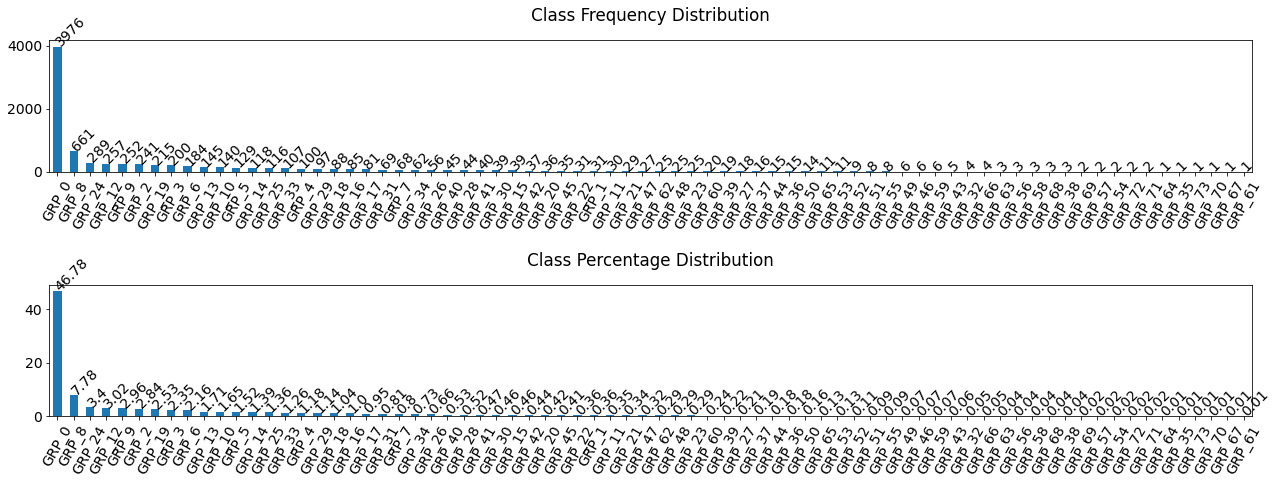

In [7]:
MultiClassDataDistribution(df[AssignmentGroup])

**Inference**


*   After analysing the graph & value counts it is evident that the Target column distribution is extremely skewed. There are 74 distinct assignment groups
*   GRP_0 is the most dominent assignment group with accounts fot 46.77 % of the dataset
*   There are many groups that have only 1 or 2 entries like GRP_70, GRP_67, GRP_71, GRP_72 etc.
*   To reduce the imbalance in the Target column to an extent, we can merge the groups with small entries which are contributing less than 0.25 % (or < 25 entries) to the data into a miscellaneous group.

##### Merging Small Groups & Visualization

In [8]:
# Merge the groups with small entires to MISC group
grpList = df.groupby([AssignmentGroup])
regroup=[]
for grp in df[AssignmentGroup].unique():
  if(grpList.get_group(grp).shape[0] < 25):
    regroup.append(grp)

print('Found {} groups which have under 25 samples'.format(len(regroup)))
df[AssignmentGroup] = df[AssignmentGroup].apply(lambda x : 'MISC' if x in regroup  else x)

df[AssignmentGroup].unique()

Found 34 groups which have under 25 samples


array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'MISC', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31', 'GRP_33',
       'GRP_34', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_45', 'GRP_47',
       'GRP_48', 'GRP_62'], dtype=object)

Total no. of unique values are 41


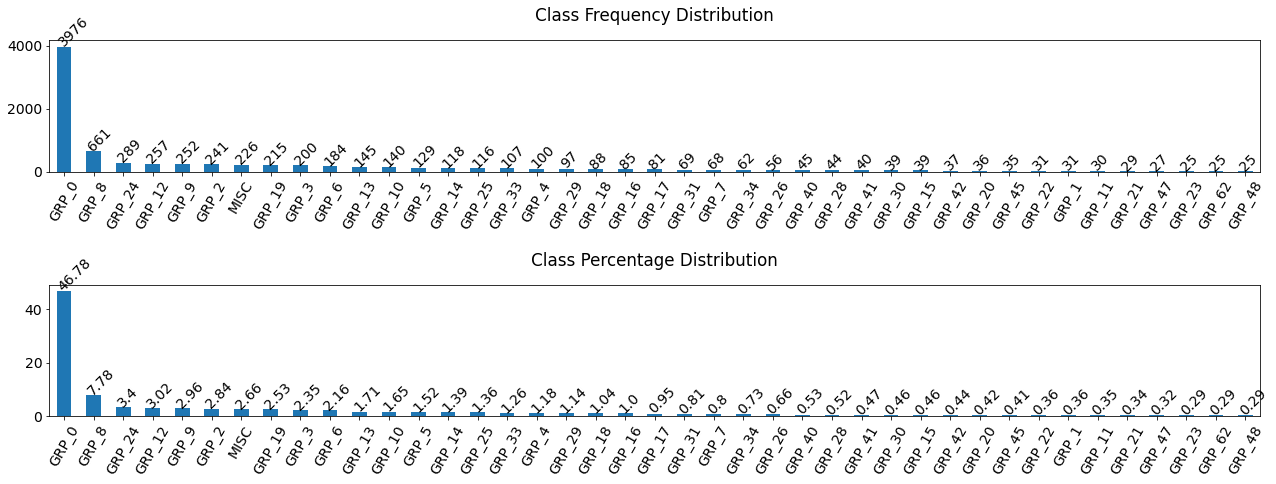

In [9]:
MultiClassDataDistribution(df[AssignmentGroup])

### Duplicate Data

In [10]:
duplicate_df = df[df.duplicated()]
duplicate_df.head(25)

Short description  ... Assignment group
51                     call for ecwtrjnq jpecxuty  ...            GRP_0
81                      erp SID_34 account locked  ...            GRP_0
123              unable to display expense report  ...            GRP_0
157                            ess password reset  ...            GRP_0
229                    call for ecwtrjnq jpecxuty  ...            GRP_0
235  erp SID_34 account unlock and password reset  ...            GRP_0
242                        windows password reset  ...            GRP_0
274                       windows account locked   ...            GRP_0
301                        windows password reset  ...            GRP_0
312                     erp SID_34 account unlock  ...            GRP_0
333                        windows password reset  ...            GRP_0
380                 unable to login to erp SID_34  ...            GRP_0
391                        password reset request  ...            GRP_0
393                               password reset   ...            GRP_0
422                                password reset  ...            GRP_0
493               ticket update on inplant_872730  ...            GRP_0
512                              blank call //gso  ...            GRP_0
516                        outlook freezing issue  ...            GRP_0
526                                password reset  ...            GRP_0
544                        unable to open outlook  ...            GRP_0
571                    erp SID_34 password reset.  ...            GRP_0
580                     erp SID_34 account locked  ...            GRP_0
584  erp SID_34 account unlock and password reset  ...            GRP_0
587                                   login issue  ...            GRP_0
662                     erp SID_34 account locked  ...            GRP_0

[25 rows x 3 columns]

In [11]:
duplicate_df[AssignmentGroup].value_counts()

GRP_0     547
GRP_8      16
GRP_17     13
GRP_24      4
MISC        4
GRP_5       1
GRP_4       1
GRP_19      1
GRP_12      1
GRP_6       1
GRP_15      1
GRP_21      1
Name: Assignment group, dtype: int64

*   There are 591 rows that are duplicate in the dataset.
*   Since majority of them have the assignment group as GRP_0, we can delete these records. It will also help to reduce the imbalance in data a bit.



In [12]:
df = df.drop_duplicates([ShortDescription, Description, AssignmentGroup])
print("Data Shape after dropping Duplicate Values:", df.shape)

Data Shape after dropping Duplicate Values: (7909, 3)


### Missing Values

In [13]:
df.isnull().sum()

Short description    5
Description          1
Assignment group     0
dtype: int64

In [14]:
df[df.isnull().any(axis=1)]

Short description  ... Assignment group
2604                       NaN  ...           GRP_34
3383                       NaN  ...            GRP_0
3906                       NaN  ...            GRP_0
3924                       NaN  ...            GRP_0
4341                       NaN  ...            GRP_0
4395  i am locked out of skype  ...            GRP_0

[6 rows x 3 columns]



*   There are 6 six missing values in the dataset.
*   We will replace them by empty string and continue processing.



In [15]:
df[ShortDescription].replace(np.NaN, ' ', inplace=True)
df[Description].replace(np.NaN, ' ', inplace=True)
print("Data Shape after dropping Missing Values:", df.shape)
df.isnull().sum()

Data Shape after dropping Missing Values: (7909, 3)


Short description    0
Description          0
Assignment group     0
dtype: int64

### Visualize Text Features

In [16]:
import nltk

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.probability import FreqDist

def ShowWordCloud(data):
  words = []
  for val in data:       
    # typecaste each val to string 
    val = str(val)  
    # split the value 
    tokens = val.split()       
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
      tokens[i] = str(tokens[i].lower())
    words += tokens
  
  freq_words = nltk.FreqDist(words)
  words = dict([(m, n) for m, n in freq_words.items()])

  wordcloud = WordCloud(width=1024, height=786,
                        background_color='black',
                        random_state = RANDOM_STATE,
                        colormap="Blues",
                        collocations=False)
  wordcloud.generate_from_frequencies(words)
  plt.figure(figsize = (20,10))
  plt.axis("off")
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.show()
  TopNWordsInText(data)

def TopNWordsInText(data, n = 20):
  vectorizer = CountVectorizer(ngram_range = (1, 1), analyzer = 'word')
  matrix = vectorizer.fit_transform(data)
  freq = sum(matrix).toarray()[0]
  freq_df = pd.DataFrame(freq, index=vectorizer.get_feature_names(), columns=['Frequency'])
  top_n_df = freq_df.sort_values(by = "Frequency", ascending = False).head(n)
  ax = top_n_df.head(n).plot(figsize=(12,8), kind="barh", title="Top " + str(n) + " Frequent Words")
  SetHorizontalBarValues(ax)

#### Short Description

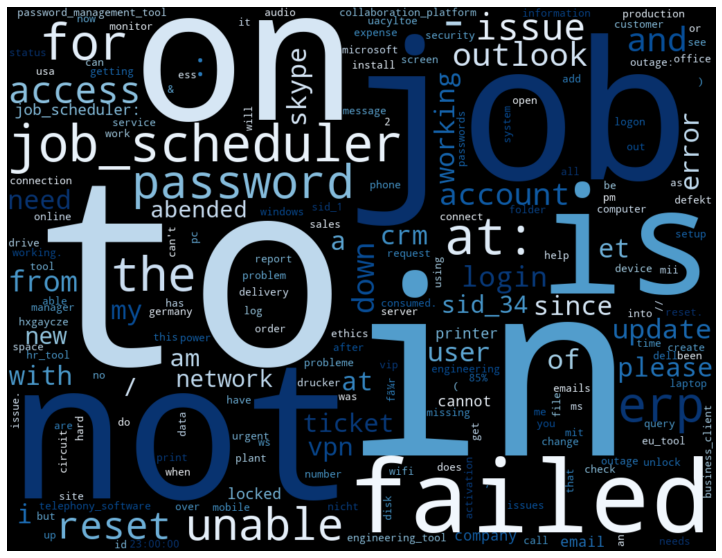

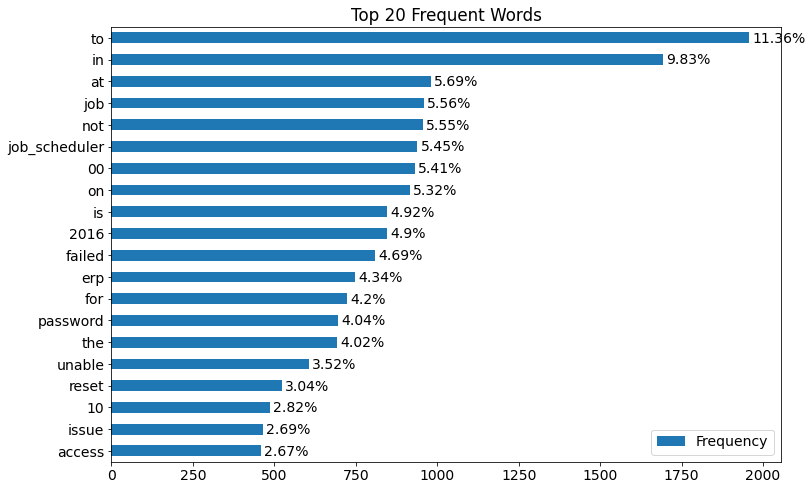

In [17]:
ShowWordCloud(df[ShortDescription])

**The graph indicates that the top words in Short Description are stop words i.e to, in, at, on, is etc. The other prominent words are job, job_scheduler, failed, erp etc**

#### Description

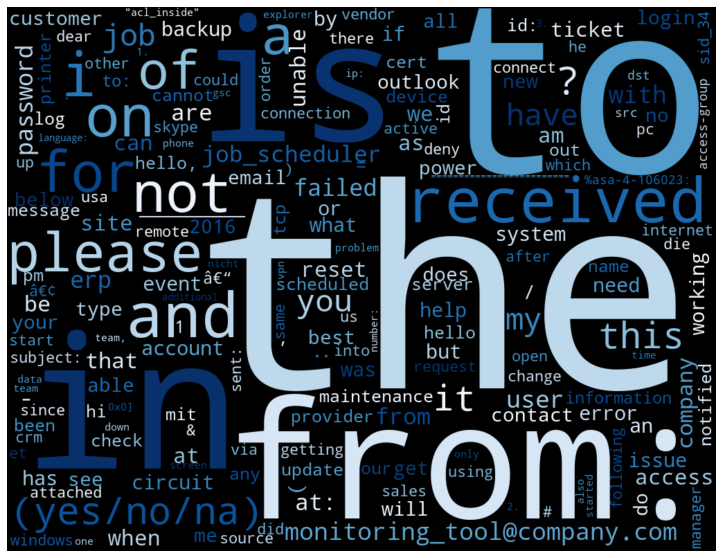

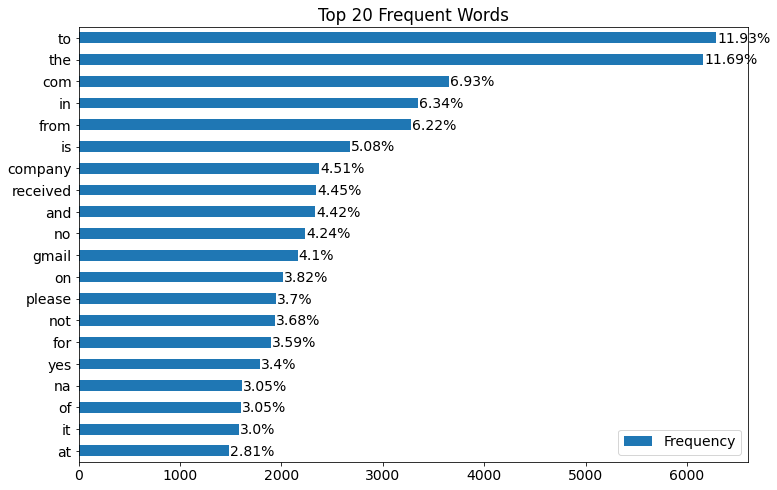

In [18]:
ShowWordCloud(df[Description])

**Inference:**
*   The graph indicates that the top words in Description also include stop words i.e to, in, the, from, is etc. The other prominent words include company, received, gmail etc.
*   It is evident from the Work Cloud & Bar plot of Top words that both the columns i.e. Short Description & Description are focussing on different set of words (excluding the stopwords). This also indicates that both are required to predict the correct assignment group.




### Merge Text Features

Looking at the data we could find that both short description as well as description gives some information about the ticket. In some cases both are same & in some cases short description has proper text & description doesn't have any meaningful text. Hence, we can combine Short Description & Description as one column.

In [19]:
df["Full Description"] = df[ShortDescription].map(str) + ' ' + df[Description].map(str)
df.head(25)

Short description  ...                                   Full Description
0                                         login issue  ...  login issue -verified user details.(employee# ...
1                                             outlook  ...  outlook \r\n\r\nreceived from: hmjdrvpb.komuay...
2                                  cant log in to vpn  ...  cant log in to vpn \r\n\r\nreceived from: eylq...
3                       unable to access hr_tool page  ...  unable to access hr_tool page unable to access...
4                                        skype error   ...                          skype error  skype error 
5      unable to log in to engineering tool and skype  ...  unable to log in to engineering tool and skype...
6   event: critical:HostName_221.company.com the v...  ...  event: critical:HostName_221.company.com the v...
7   ticket_no1550391- employment status - new non-...  ...  ticket_no1550391- employment status - new non-...
8                unable to disable add ins on outlook  ...  unable to disable add ins on outlook unable to...
9                     ticket update on inplant_874773  ...  ticket update on inplant_874773 ticket update ...
10  engineering tool says not connected and unable...  ...  engineering tool says not connected and unable...
11            hr_tool site not loading page correctly  ...  hr_tool site not loading page correctly hr_too...
12  unable to login to hr_tool to sgxqsuojr xwbeso...  ...  unable to login to hr_tool to sgxqsuojr xwbeso...
13                   user wants to reset the password  ...  user wants to reset the password user wants to...
14                           unable to open payslips   ...  unable to open payslips  unable to open payslips 
15                    ticket update on inplant_874743  ...  ticket update on inplant_874743 ticket update ...
16                     unable to login to company vpn  ...  unable to login to company vpn \n\nreceived fr...
17      when undocking pc , screen will not come back  ...  when undocking pc , screen will not come back ...
18                          erp SID_34 account locked  ...  erp SID_34 account locked erp SID_34 account l...
19                            unable to sign into vpn  ...    unable to sign into vpn unable to sign into vpn
20                           unable to check payslips  ...  unable to check payslips unable to check payslips
21                                          vpn issue  ...  vpn issue \r\n\r\nreceived from: ugephfta.hrbq...
22                           unable to connect to vpn  ...  unable to connect to vpn unable to connect to vpn
23                user called for vendor phone number  ...  user called for vendor phone number user calle...
24                                    vpn not working  ...  vpn not working \n\nreceived from: dceoufyz.sa...

[25 rows x 4 columns]

**Due to our last activity of combining columns, we can see that there are duplicate words in the new Full Description column. Hence we will delete the "duplicates words" in Full Description column**

In [20]:
OriginalDescription = "Original Description"
# Deleting the duplicates words
df["Full Description"] = df["Full Description"].apply(lambda x:' '.join(pd.unique(x.split())))

# Copying the data frame with Merged Description
merged_df = df.copy()
df.to_excel("Combined-Text-Features-Data.xlsx", index=False)

# Pick required column & Rename to Description for further processing
df = df[['Full Description', AssignmentGroup]]
df.rename(columns={"Full Description": OriginalDescription}, inplace=True)

merged_df.head(25)

Short description  ...                                   Full Description
0                                         login issue  ...  login issue -verified user details.(employee# ...
1                                             outlook  ...  outlook received from: hmjdrvpb.komuaywn@gmail...
2                                  cant log in to vpn  ...  cant log in to vpn received from: eylqgodm.ybq...
3                       unable to access hr_tool page  ...                      unable to access hr_tool page
4                                        skype error   ...                                        skype error
5      unable to log in to engineering tool and skype  ...        unable to log in engineering tool and skype
6   event: critical:HostName_221.company.com the v...  ...  event: critical:HostName_221.company.com the v...
7   ticket_no1550391- employment status - new non-...  ...  ticket_no1550391- employment status - new non-...
8                unable to disable add ins on outlook  ...               unable to disable add ins on outlook
9                     ticket update on inplant_874773  ...                    ticket update on inplant_874773
10  engineering tool says not connected and unable...  ...  engineering tool says not connected and unable...
11            hr_tool site not loading page correctly  ...            hr_tool site not loading page correctly
12  unable to login to hr_tool to sgxqsuojr xwbeso...  ...   unable to login hr_tool sgxqsuojr xwbesorf cards
13                   user wants to reset the password  ...                   user wants to reset the password
14                           unable to open payslips   ...                            unable to open payslips
15                    ticket update on inplant_874743  ...                    ticket update on inplant_874743
16                     unable to login to company vpn  ...  unable to login company vpn received from: xyz...
17      when undocking pc , screen will not come back  ...      when undocking pc , screen will not come back
18                          erp SID_34 account locked  ...                          erp SID_34 account locked
19                            unable to sign into vpn  ...                            unable to sign into vpn
20                           unable to check payslips  ...                           unable to check payslips
21                                          vpn issue  ...  vpn issue received from: ugephfta.hrbqkvij@gma...
22                           unable to connect to vpn  ...                              unable to connect vpn
23                user called for vendor phone number  ...                user called for vendor phone number
24                                    vpn not working  ...  vpn not working received from: dceoufyz.saufqk...

[25 rows x 4 columns]

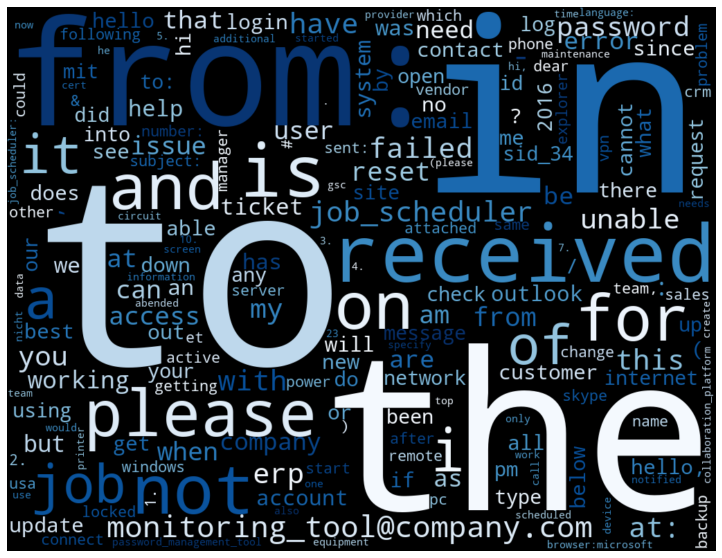

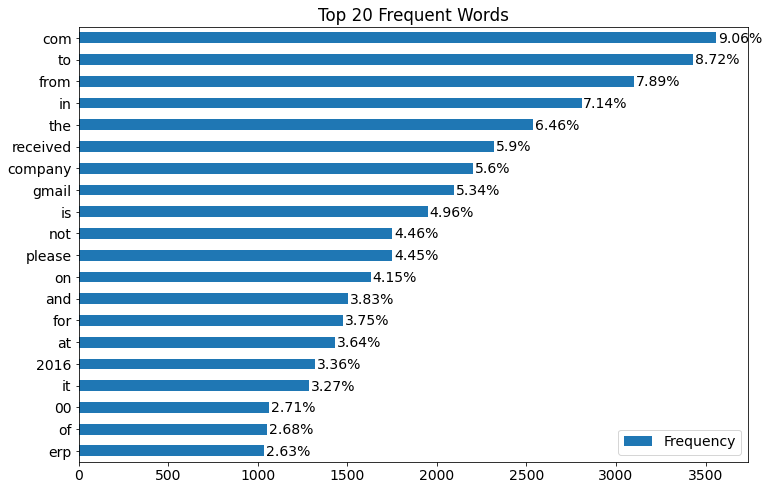

In [21]:
ShowWordCloud(df[OriginalDescription])

**Inference**
*   The Word Cloud & Bar plot of Full Description clearly show that it is an amalgamation of both Short Description & Description.
*   We will use Full Description for further processing of data.
*   We can also observe unicode characters, numbers, special characters in the Word Cloud. We need to process them in the dataset first before passing it to the model.

### Text Pre-processing
Pre-processing is mandatory to get the data in a consistent format. We will create a function which will perform the following tasks on the text columns:
*   Handle Unicode Characters
*   Make text lowercase
*   Remove hyperlinks
*   Remove punctuation
*   Remove numbers
*   Remove special characters
*   Remove HTML tags, unwanted spacing
*   Disclaimer statements etc.



#### Unicode Characters
Combined Description column has many unicode characters. We can fix this using the python library ftfy.

In [22]:
!pip install ftfy

     |████████████████████████████████| 71kB 5.1MB/s 
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45613 sha256=72cb0acb7f0b34ed5f57f519dc969df2b1429e2023a2728b5b59489fc7ebdd8e
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
Successfully built ftfy


In [23]:
import ftfy
df["Decoded Description"] = df[OriginalDescription].apply(lambda x: ftfy.fix_text(x))

# Copying the data frame with Decoded Description
fixed_df = df.copy()
df.to_excel("Unicode-Fixed-Data.xlsx", index=False)

# Pick required column & Rename to Description for further processing
df = df[['Decoded Description', AssignmentGroup, OriginalDescription]]
df.rename(columns={"Decoded Description": Description}, inplace=True)

fixed_df.head(25)

Original Description  ...                                Decoded Description
0   login issue -verified user details.(employee# ...  ...  login issue -verified user details.(employee# ...
1   outlook received from: hmjdrvpb.komuaywn@gmail...  ...  outlook received from: hmjdrvpb.komuaywn@gmail...
2   cant log in to vpn received from: eylqgodm.ybq...  ...  cant log in to vpn received from: eylqgodm.ybq...
3                       unable to access hr_tool page  ...                      unable to access hr_tool page
4                                         skype error  ...                                        skype error
5         unable to log in engineering tool and skype  ...        unable to log in engineering tool and skype
6   event: critical:HostName_221.company.com the v...  ...  event: critical:HostName_221.company.com the v...
7   ticket_no1550391- employment status - new non-...  ...  ticket_no1550391- employment status - new non-...
8                unable to disable add ins on outlook  ...               unable to disable add ins on outlook
9                     ticket update on inplant_874773  ...                    ticket update on inplant_874773
10  engineering tool says not connected and unable...  ...  engineering tool says not connected and unable...
11            hr_tool site not loading page correctly  ...            hr_tool site not loading page correctly
12   unable to login hr_tool sgxqsuojr xwbesorf cards  ...   unable to login hr_tool sgxqsuojr xwbesorf cards
13                   user wants to reset the password  ...                   user wants to reset the password
14                            unable to open payslips  ...                            unable to open payslips
15                    ticket update on inplant_874743  ...                    ticket update on inplant_874743
16  unable to login company vpn received from: xyz...  ...  unable to login company vpn received from: xyz...
17      when undocking pc , screen will not come back  ...      when undocking pc , screen will not come back
18                          erp SID_34 account locked  ...                          erp SID_34 account locked
19                            unable to sign into vpn  ...                            unable to sign into vpn
20                           unable to check payslips  ...                           unable to check payslips
21  vpn issue received from: ugephfta.hrbqkvij@gma...  ...  vpn issue received from: ugephfta.hrbqkvij@gma...
22                              unable to connect vpn  ...                              unable to connect vpn
23                user called for vendor phone number  ...                user called for vendor phone number
24  vpn not working received from: dceoufyz.saufqk...  ...  vpn not working received from: dceoufyz.saufqk...

[25 rows x 3 columns]

**Dataset is cleaned from all the Unicode characters and the same is saved in an excel file "Unicode-Fixed-Data.xlsx" for future reference.**

#### Language Translation

The Combined Description has text from different languages. We can fix this using the Google Translate API in python.

In [24]:
!pip install google_trans_new

In [25]:
from google_trans_new import google_translator 
translator = google_translator()

def DetectLanguage(row):
  try:
    language = detect(row)
  except:
    language = "en"
  return language

def TranslateLanguage(row):
  try:
    result = translator.translate(row, lang_tgt='en')
  except:
    print(row)
    result = row
  return result

In [26]:
# INTRODUCED LOAD_FROM_FILE FLAG SINCE IT IS TIME INTENSIVE AND TAKES AROUND 10 MINUTES TO TRANSLATE EACH WORD IN THE DESCRIPTION COLUMN
# HAVE STORED THE DATA IN EXCEL. WILL LOAD THAT IN ORDER TO SAVE COMPUTATION TIME

if LOAD_FROM_FILE == 0 :
  df["Translated Description"] = df[Description].apply(lambda x: TranslateLanguage(x))
else:
  df = pd.read_excel(datasetPath + 'Translated-Data.xlsx')
df = df.dropna(how='any',axis=0)

# Copying the data frame with Translated Description
translated_df = df.copy()
df.to_excel("Translated-Data.xlsx", index=False)
%cp /content/Translated-Data.xlsx /content/drive/My\ Drive/GL/Capstone

# Pick required column & Rename to Description for further processing
df = df[['Translated Description', AssignmentGroup, OriginalDescription]]
df.rename(columns={"Translated Description": Description}, inplace=True)

print("Data Shape:", translated_df.shape)
translated_df.head(25)

Data Shape: (7909, 4)


Description  ...                             Translated Description
0   login issue -verified user details.(employee# ...  ...  login issue -verified user details.(employee# ...
1   outlook received from: hmjdrvpb.komuaywn@gmail...  ...  outlook received from: hmjdrvpb.komuaywn@gmail...
2   cant log in to vpn received from: eylqgodm.ybq...  ...  cant log in to vpn received from: eylqgodm.ybq...
3                       unable to access hr_tool page  ...                     unable to access hr_tool page 
4                                         skype error  ...                                       skype error 
5         unable to log in engineering tool and skype  ...       unable to log in engineering tool and skype 
6   event: critical:HostName_221.company.com the v...  ...  event: critical:HostName_221.company.com the v...
7   ticket_no1550391- employment status - new non-...  ...  ticket_no1550391- employment status - new non-...
8                unable to disable add ins on outlook  ...              unable to disable add ins on outlook 
9                     ticket update on inplant_874773  ...                   ticket update on inplant_874773 
10  engineering tool says not connected and unable...  ...  engineering tool says not connected and unable...
11            hr_tool site not loading page correctly  ...           hr_tool site not loading page correctly 
12   unable to login hr_tool sgxqsuojr xwbesorf cards  ...  unable to login hr_tool sgxqsuojr xwbesorf cards 
13                   user wants to reset the password  ...                  user wants to reset the password 
14                            unable to open payslips  ...                           unable to open payslips 
15                    ticket update on inplant_874743  ...                   ticket update on inplant_874743 
16  unable to login company vpn received from: xyz...  ...  unable to login company vpn received from: xyz...
17      when undocking pc , screen will not come back  ...     when undocking pc , screen will not come back 
18                          erp SID_34 account locked  ...                         erp SID_34 account locked 
19                            unable to sign into vpn  ...                           unable to sign into vpn 
20                           unable to check payslips  ...                          unable to check payslips 
21  vpn issue received from: ugephfta.hrbqkvij@gma...  ...  vpn issue received from: ugephfta.hrbqkvij@gma...
22                              unable to connect vpn  ...                             unable to connect vpn 
23                user called for vendor phone number  ...               user called for vendor phone number 
24  vpn not working received from: dceoufyz.saufqk...  ...  vpn not working received from: dceoufyz.saufqk...

[25 rows x 4 columns]

**Dataset is translated from other languages to English language and the same is saved in an excel file "Translated-Data.xlsx" for future reference. Still there are many non english words which do not make any sense hence will clean them before processing**



#### Text Cleansing / Pre-processing

Even after Language Translation we can see words that do not make any sense. Thus, installing the nostril library to detect such jitted words and remove whatever is possible from the dataset. Thus ensuring less overall Word Vocabulary size

In [27]:
!sudo pip3 install git+https://github.com/casics/nostril.git
!pip install clean-text[gpl]

  Cloning https://github.com/casics/nostril.git to /tmp/pip-req-build-qum1iu2l
  Running command git clone -q https://github.com/casics/nostril.git /tmp/pip-req-build-qum1iu2l
  Created wheel for nostril: filename=nostril-1.2.0-cp36-none-any.whl size=5765781 sha256=8cb328d6d968149bccb1f354b4d2434829a0b3dd3c9e730c33cb68aa5d15f805
  Stored in directory: /tmp/pip-ephem-wheel-cache-8yjjqbem/wheels/a8/1f/92/4bff497c4594eddc2834fcc04aba606674f0758befd18c8aef
Successfully built nostril
     |████████████████████████████████| 51kB 4.0MB/s 
     |████████████████████████████████| 245kB 10.8MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49717 sha256=7d19d663a279ae7a59b03c039b615e0bc4f0244292660fc78d03e353a36f9b6f
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [28]:
import re
from nostril import nonsense
from cleantext import clean

def CleanSentence(sentence):
  # Adding regex list as per the given data set to flush off the unnecessary text
  m = clean(sentence,
      fix_unicode=True,               # fix various unicode errors
      to_ascii=True,                  # transliterate to closest ASCII representation
      lower=True,                     # lowercase text
      no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
      no_urls=True,                  # replace all URLs with a special token
      no_emails=True,                # replace all email addresses with a special token
      no_phone_numbers=True,         # replace all phone numbers with a special token
      no_numbers=True,               # replace all numbers with a special token
      no_digits=True,                # replace all digits with a special token
      no_currency_symbols=True,      # replace all currency symbols with a special token
      no_punct=True,                 # remove punctuations
      replace_with_punct=" ",          # instead of removing punctuations you may replace them
      replace_with_url="",
      replace_with_email="",
      replace_with_phone_number="",
      replace_with_number="",
      replace_with_digit="",
      replace_with_currency_symbol="",
      lang="en"                       # set to 'de' for German special handling
  )
  m = ' '.join([w for w in m.split() if len(w) <= 15])
  m = re.sub('from:(.*)\\r\\n', '', m) # from line
  m = re.sub('sent:(.*)\\r\\n', '', m) # sent to line
  m = re.sub('received from:(.*)\\r\\n', '', m) # received data line
  m = re.sub('received', '', m) # received data line
  m = re.sub('to:(.*)\\r\\n', '', m) # to line
  m = re.sub('cc:(.*)\\r\\n', '', m) # cc line
  m = re.sub('(.*)infection', '', m) # footer
  m = re.sub('\\[cid:(.*)]', '', m) # images cid
  m = re.sub('https?:[^\\]\\n\\r]+', '', m) # https & http
  m = re.sub('subject: ', '', m) # Subject word
  m = re.sub('[\\w\\d\\-\\_\\.]+@[\\w\\d\\-\\_\\.]+', '', m) # emails are not required
  m = re.sub('[0-9][\\-0–90-9 ]+', '', m) # phones are not required
  m = re.sub('[0-9]', '', m) # numbers not needed
  m = re.sub('[^a-zA-z 0-9]+', '', m) # anything that is not a letter
  m = re.sub('[\\r\\n]', '', m) # \\r\\n
  m = RemoveNonsenseWords(m)
  m = re.sub(' [a-zA-Z] ', ' ', m) # single letters makes no sense
  return ' '.join(m.split())

def RemoveNonsenseWords(sentence):
  words = []
  for w in sentence.split():
    try:
      if not nonsense(w):
        words.append(w)
    except:
      words.append(w)
  return ' '.join([str(elem) for elem in words]) 

In [29]:
# INTRODUCED LOAD_FROM_FILE FLAG SINCE IT IS TIME INTENSIVE AND TAKES AROUND 40 MINUTES TO CLEAN EACH WORD IN THE DESCRIPTION COLUMN
# HAVE STORED THE DATA IN EXCEL. WILL LOAD THAT IN ORDER TO SAVE COMPUTATION TIME

if LOAD_FROM_FILE == 0 :
  df["Clean Description"] = df[Description].apply(lambda x: CleanSentence(x))
else:
  df = pd.read_excel(datasetPath + 'Cleaned-Data.xlsx')
df = df.dropna(how='any',axis=0)

# Copying the data frame with Cleaned Description
cleaned_df = df.copy()
df.to_excel('Cleaned-Data.xlsx', index=False)
%cp /content/Cleaned-Data.xlsx /content/drive/My\ Drive/GL/Capstone

# Pick required column & Rename to Description for further processing
df = df[['Clean Description', AssignmentGroup, OriginalDescription]]
df.rename(columns={"Clean Description": Description}, inplace=True)

print("Data Shape:", cleaned_df.shape)
cleaned_df.head(25)

Data Shape: (7907, 4)


Description  ...                                  Clean Description
0   login issue -verified user details.(employee# ...  ...  login issue verified user details employee man...
1   outlook received from: hmjdrvpb.komuaywn@gmail...  ...  outlook from hello team my meetings skype meet...
2   cant log in to vpn received from: eylqgodm.ybq...  ...          cant log in to vpn from hi cannot on best
3                      unable to access hr_tool page   ...                      unable to access hr tool page
4                                        skype error   ...                                        skype error
5        unable to log in engineering tool and skype   ...        unable to log in engineering tool and skype
6   event: critical:HostName_221.company.com the v...  ...  event critical hostname company com the value ...
7   ticket_no1550391- employment status - new non-...  ...  ticket no employment status new non employee e...
8               unable to disable add ins on outlook   ...               unable to disable add ins on outlook
9                    ticket update on inplant_874773   ...                           ticket update on inplant
10  engineering tool says not connected and unable...  ...  engineering tool says not connected and unable...
11           hr_tool site not loading page correctly   ...            hr tool site not loading page correctly
12  unable to login hr_tool sgxqsuojr xwbesorf cards   ...             unable to login hr tool xwbesorf cards
13                  user wants to reset the password   ...                   user wants to reset the password
14                           unable to open payslips   ...                            unable to open payslips
15                   ticket update on inplant_874743   ...                           ticket update on inplant
16  unable to login company vpn received from: xyz...  ...  unable to login company vpn from hi am website...
17     when undocking pc , screen will not come back   ...        when undocking pc screen will not come back
18                         erp SID_34 account locked   ...                             erp sid account locked
19                           unable to sign into vpn   ...                            unable to sign into vpn
20                          unable to check payslips   ...                           unable to check payslips
21  vpn issue received from: ugephfta.hrbqkvij@gma...  ...  vpn issue from hello helpdesk am not able to c...
22                             unable to connect vpn   ...                              unable to connect vpn
23               user called for vendor phone number   ...                user called for vendor phone number
24  vpn not working received from: dceoufyz.saufqk...  ...  vpn not working from hello m being able to con...

[25 rows x 4 columns]

In [30]:
def ReplaceWords(m): 
  m = m.replace('aerp', 'asap')
  m = m.replace('amerirtca', 'america')  
  m = m.replace('rtr', 'router')
  m = m.replace('sid', 'id')
  m = m.replace('wi fi', 'wifi') 
  m = m.replace('log in', 'login')  
  m = m.replace('can not', 'cannot')  
  m = m.replace('add in', 'addin')
  m = re.sub(' [a-zA-Z] ', ' ', m) # single letters makes no sense
  return ' '.join(m.split())

In [31]:
df["Clean Description"] = df[Description].apply(lambda x: ReplaceWords(x))
df = df.dropna(how='any',axis=0)

# Copying the data frame with Cleaned Description
cleaned_df = df.copy()
df.to_excel('Final-Cleaned-Data.xlsx', index=False)

# Pick required column & Rename to Description for further processing
df = df[['Clean Description', AssignmentGroup, OriginalDescription]]
df.rename(columns={"Clean Description": Description}, inplace=True)

cleaned_df.head(25)

Description  ...                                  Clean Description
0   login issue verified user details employee man...  ...  login issue verified user details employee man...
1   outlook from hello team my meetings skype meet...  ...  outlook from hello team my meetings skype meet...
2           cant log in to vpn from hi cannot on best  ...           cant login to vpn from hi cannot on best
3                       unable to access hr tool page  ...                      unable to access hr tool page
4                                         skype error  ...                                        skype error
5         unable to log in engineering tool and skype  ...         unable to login engineering tool and skype
6   event critical hostname company com the value ...  ...  event critical hostname company com the value ...
7   ticket no employment status new non employee e...  ...  ticket no employment status new non employee e...
8                unable to disable add ins on outlook  ...                unable to disable addins on outlook
9                            ticket update on inplant  ...                           ticket update on inplant
10  engineering tool says not connected and unable...  ...  engineering tool says not connected and unable...
11            hr tool site not loading page correctly  ...            hr tool site not loading page correctly
12             unable to login hr tool xwbesorf cards  ...             unable to login hr tool xwbesorf cards
13                   user wants to reset the password  ...                   user wants to reset the password
14                            unable to open payslips  ...                            unable to open payslips
15                           ticket update on inplant  ...                           ticket update on inplant
16  unable to login company vpn from hi am website...  ...  unable to login company vpn from hi am website...
17        when undocking pc screen will not come back  ...        when undocking pc screen will not come back
18                             erp sid account locked  ...                              erp id account locked
19                            unable to sign into vpn  ...                            unable to sign into vpn
20                           unable to check payslips  ...                           unable to check payslips
21  vpn issue from hello helpdesk am not able to c...  ...  vpn issue from hello helpdesk am not able to c...
22                              unable to connect vpn  ...                              unable to connect vpn
23                user called for vendor phone number  ...                user called for vendor phone number
24  vpn not working from hello m being able to con...  ...  vpn not working from hello being able to conne...

[25 rows x 4 columns]

### Visualizing Post Processing

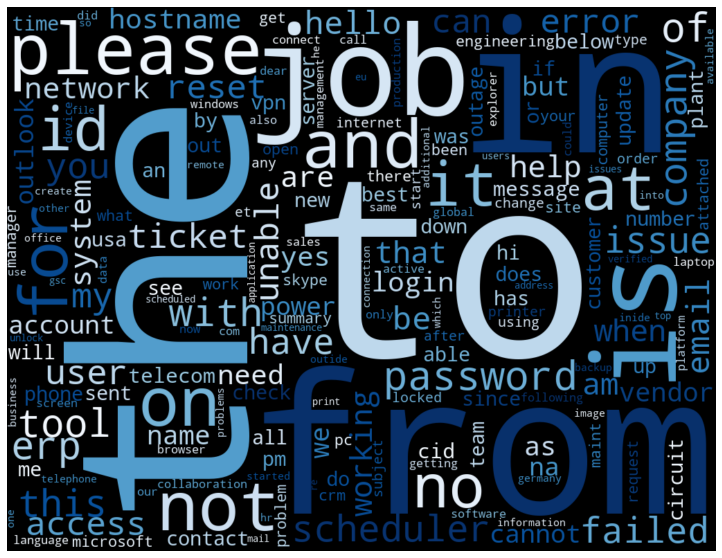

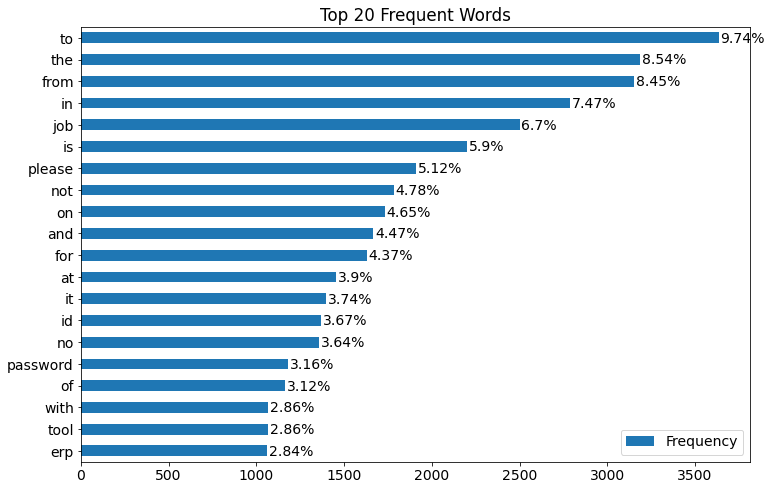

In [32]:
ShowWordCloud(df[Description])

*   Word Cloud has overall changed significantly after performing text processing. The numbers & special characters have disappeared.
*   Still dataset is prominently showing that the most frequent words are Stop words which needs to be taken care of based on the model to be implemented.







### Lemmatization

In [33]:
!pip install spacy

In [34]:
import spacy
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])

def LemmatizeSentence(sentence):
  doc = nlp(sentence)
  return " ".join([token.text if token.lemma_ == "-PRON-" else token.lemma_ for token in doc])

In [35]:
# INTRODUCED LOAD_FROM_FILE FLAG SINCE IT TAKES TIME TO LEMMATIZE EACH WORD IN THE DESCRIPTION COLUMN
# HAVE STORED THE DATA IN EXCEL. WILL LOAD THAT IN ORDER TO SAVE COMPUTATION TIME

if LOAD_FROM_FILE == 0 :
  df["Lemmatized Description"] = df[Description].apply(lambda x: LemmatizeSentence(x))
else:
  df = pd.read_excel(datasetPath + 'Lemmatized-Data.xlsx')
df = df.dropna(how='any',axis=0)

# Copying the data frame with Lemmatized Description
lemmatized_df = df.copy()
df.to_excel('Lemmatized-Data.xlsx', index=False)
%cp /content/Lemmatized-Data.xlsx /content/drive/My\ Drive/GL/Capstone

# Pick required column & Rename to Description for further processing
df = df[['Lemmatized Description', AssignmentGroup, OriginalDescription]]
df.rename(columns={"Lemmatized Description": Description}, inplace=True)

print("Data Shape:", lemmatized_df.shape)
lemmatized_df.head(25)

Data Shape: (7907, 4)


Description  ...                             Lemmatized Description
0   login issue verified user details employee man...  ...  login issue verify user detail employee manage...
1   outlook from hello team my meetings skype meet...  ...  outlook from hello team my meeting skype meeti...
2            cant login to vpn from hi cannot on best  ...       can not login to vpn from hi can not on best
3                       unable to access hr tool page  ...                      unable to access hr tool page
4                                         skype error  ...                                        skype error
5          unable to login engineering tool and skype  ...         unable to login engineering tool and skype
6   event critical hostname company com the value ...  ...  event critical hostname company com the value ...
7   ticket no employment status new non employee e...  ...  ticket no employment status new non employee e...
8                 unable to disable addins on outlook  ...                 unable to disable addin on outlook
9                            ticket update on inplant  ...                           ticket update on inplant
10  engineering tool says not connected and unable...  ...  engineering tool say not connect and unable to...
11            hr tool site not loading page correctly  ...               hr tool site not load page correctly
12             unable to login hr tool xwbesorf cards  ...             unable to login hr tool xwbesorf cards
13                   user wants to reset the password  ...                    user want to reset the password
14                            unable to open payslips  ...                             unable to open payslip
15                           ticket update on inplant  ...                           ticket update on inplant
16  unable to login company vpn from hi am website...  ...  unable to login company vpn from hi am website...
17        when undocking pc screen will not come back  ...        when undocking pc screen will not come back
18                              erp id account locked  ...                           erp i would account lock
19                            unable to sign into vpn  ...                            unable to sign into vpn
20                           unable to check payslips  ...                            unable to check payslip
21  vpn issue from hello helpdesk am not able to c...  ...  vpn issue from hello helpdesk be not able to c...
22                              unable to connect vpn  ...                              unable to connect vpn
23                user called for vendor phone number  ...                  user call for vendor phone number
24  vpn not working from hellobeing able to connec...  ...  vpn not work from hellobee able to connect com...

[25 rows x 4 columns]

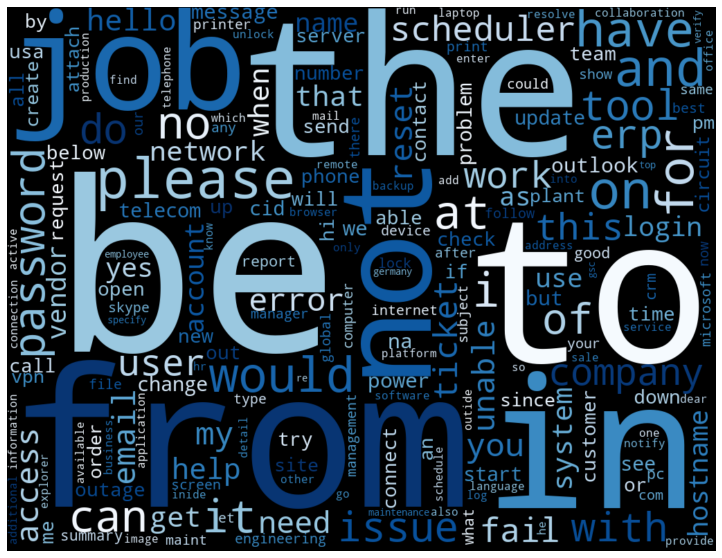

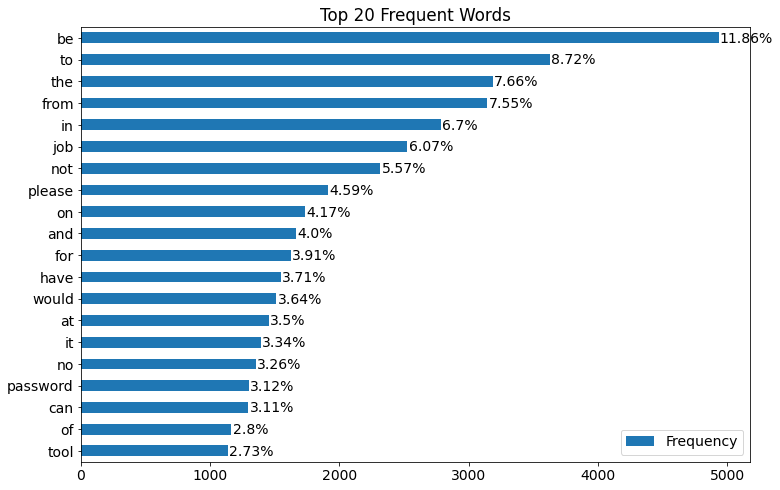

In [36]:
ShowWordCloud(df[Description])

**Word Cloud has not changed that much after Lemmatization. The dataset continue to have stop words occuring more frequently.**

### Stop Word Removal

In [37]:
all_stopwords = nlp.Defaults.stop_words
if 'not' in all_stopwords:
  all_stopwords.remove('not')
if 'call' in all_stopwords:
  all_stopwords.remove('call')
if 'out' in all_stopwords:
  all_stopwords.remove('out')

all_stopwords |= {"hi","pm","cc","usa","ve","abc","xyz","st","th","al","et","mx","cr","conn","jco","tm","na","g","sv","ef","inc","wy","cee","tel","tys","ae","aw","pi","ic","pl","pls","sr","zz" \
                  "fi","fw","ref","rak","ltm","m","mm","d","b","a","r","c","ar","eh","pu","xd","oh","oooh","o","s"}

def RemoveStopWords(sentence):
  doc = nlp(sentence)
  return " ".join([word.text for word in doc if not word.text in all_stopwords])

In [38]:
df["Processed Description"] = df[Description].apply(lambda x: RemoveStopWords(x))

# Copying the data frame with Lemmatized Description
processed_df = df.copy()
df.to_excel('Stop-Word-Removed-Data.xlsx', index=False)

# Pick required column & Rename to Description for further processing
df = df[['Processed Description', AssignmentGroup, OriginalDescription]]
df.rename(columns={"Processed Description": Description}, inplace=True)

processed_df.head(25)

Description  ...                              Processed Description
0   login issue verify user detail employee manage...  ...  login issue verify user detail employee manage...
1   outlook from hello team my meeting skype meeti...  ...  outlook hello team meeting skype meeting etc n...
2        can not login to vpn from hi can not on best  ...                             not login vpn not best
3                       unable to access hr tool page  ...                         unable access hr tool page
4                                         skype error  ...                                        skype error
5          unable to login engineering tool and skype  ...                unable login engineering tool skype
6   event critical hostname company com the value ...  ...  event critical hostname company com value moun...
7   ticket no employment status new non employee e...  ...  ticket employment status new non employee ente...
8                  unable to disable addin on outlook  ...                       unable disable addin outlook
9                            ticket update on inplant  ...                              ticket update inplant
10  engineering tool say not connect and unable to...  ...  engineering tool not connect unable submit report
11               hr tool site not load page correctly  ...               hr tool site not load page correctly
12             unable to login hr tool xwbesorf cards  ...                unable login hr tool xwbesorf cards
13                    user want to reset the password  ...                           user want reset password
14                             unable to open payslip  ...                                unable open payslip
15                           ticket update on inplant  ...                              ticket update inplant
16  unable to login company vpn from hi am website...  ...  unable login company vpn website try open new ...
17        when undocking pc screen will not come back  ...                       undocking pc screen not come
18                           erp i would account lock  ...                                   erp account lock
19                            unable to sign into vpn  ...                                    unable sign vpn
20                            unable to check payslip  ...                               unable check payslip
21  vpn issue from hello helpdesk be not able to c...  ...  vpn issue hello helpdesk not able connect home...
22                              unable to connect vpn  ...                                 unable connect vpn
23                  user call for vendor phone number  ...                      user call vendor phone number
24  vpn not work from hellobee able to connect com...  ...  vpn not work hellobee able connect company net...

[25 rows x 4 columns]

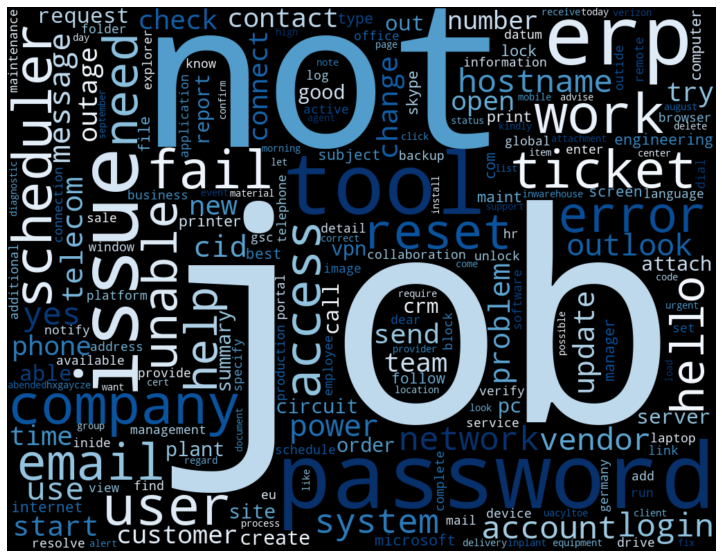

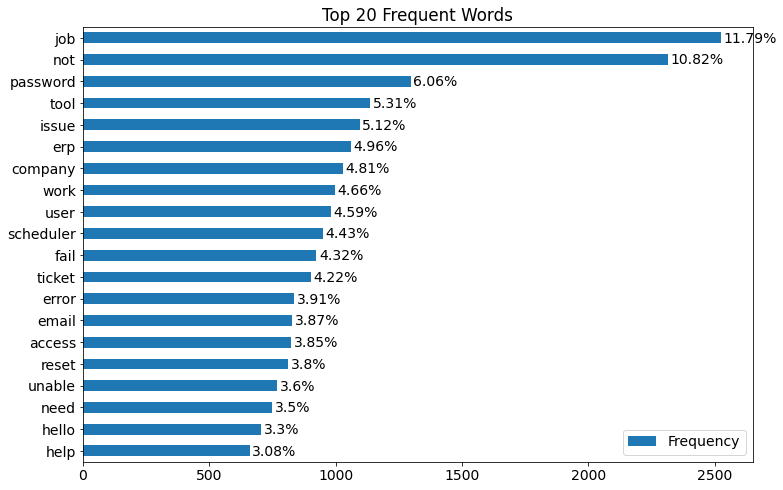

In [39]:
ShowWordCloud(df[Description])

### Word Translation

In [40]:
import nltk
nltk.download('words')
nltk.download('brown')
nltk.download('webtext')
from nltk.corpus import words
from nltk.corpus import brown
from nltk.corpus import webtext

all_words = set(nltk.corpus.words.words() + brown.words() + webtext.words())
exclusion_list = ['erp', 'scheduler', 'telecom', 'vpn', 'crm', 'skype', 'gsc', 'verizon', 'inwarehouse', 'inplant', 'screenshot', 'apac', 'iphone', 'teamviewer', 'wifi', 'hrp', 'plm', 'netweaver', \
                  'dc', 'dsw', 'workflow', 'sr', 'bex', 'gb', 'gso', 'hp', 'ewew', 'dmvpn', 'mpls', 'cvss', 'etime', 'vmax', 'vlan', 'sms', 'rpc', 'inbox', 'activesync', 'citrix', 'router', 'hr', \
                  'hostname', 'inplant', 'payslip', 'ip', 'ess', 'folder', 'pc', 'dlv', 'mm', 'sw', 'pwd', 'ave', 'cert', 'pdf', 'stack', 'cadagent', 'payroll', 'ie', 'tab', 'acrobat', 'sql', 'prod', \
                  'java', 'cpu', 'mms', 'laptop', 'datum', 'bkwin', 'app', 'kiosk', 'reset', 'eu', 'hub', 'website', 'qa', 'mfg', 'admin', 'reroute', 'browser', 'esrs', 'fwd', 'msg', 'dialog', 'asap', \
                  'lan', 'dept', 'cnc', 'vip', 'prs', 'faq', 'sso', 'hrm', 'pricing', 'wireless', 'meter', 'hcm', 'misplace', 'setup', 'quarantine', 'spamme', 'robot', 'unblock', 'scm', 'api', 'lotus', \
                  'chg', 'zdis', 'hrtool', 'ticketno', 'hostname', 'addin', 'hpqc', 'infopath', 'ipad', 'mii']

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.


**Spelling Corrector Functions**

In [41]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open(datasetPath + 'big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [42]:
from google_trans_new import google_translator 
translator = google_translator()

count = 0
def TranslateWords(row):
  global count
  count += 1
  if(count % 500 == 0):
    print(count, "rows translated.")
  words = []
  for w in nltk.wordpunct_tokenize(row):
    w = w.lower()
    if w in all_words or w in exclusion_list or not w.isalpha():      
      wrd = w
    else:
      try:
        wrd = translator.translate(w, lang_tgt='en')
      except:
        wrd = w
      wrd = correction(wrd)     
      
    words.append(wrd)
  return ' '.join([str(elem) for elem in words]) 

In [43]:
# INTRODUCED LOAD_FROM_FILE FLAG SINCE IT IS TIME INTENSIVE AND TAKES AROUND 20-25 MINUTES TO TRANSLATE EACH WORD IN THE DESCRIPTION COLUMN
# HAVE STORED THE DATA IN EXCEL. WILL LOAD THAT IN ORDER TO SAVE COMPUTATION TIME

if LOAD_FROM_FILE == 0 :
  df["Translated Description"] = df[Description].apply(lambda x: TranslateWords(x))
else:
  df = pd.read_excel(datasetPath + 'Translated-Words-Master.xlsx')
df = df.dropna(how='any',axis=0)

# Copying the data frame with Translated Description
translated_w_df = df.copy()
df.to_excel("Translated-Words-Master.xlsx", index=False)
%cp /content/Translated-Words-Master.xlsx /content/drive/My\ Drive/GL/Capstone

# Pick required column & Rename to Description for further processing
df = df[['Translated Description', AssignmentGroup, OriginalDescription]]
df.rename(columns={"Translated Description": Description}, inplace=True)

print("Data Shape:", translated_w_df.shape)
translated_w_df.head(25)

Data Shape: (7905, 4)


Description  ...                             Translated Description
0   login issue verify user detail employee manage...  ...  login issue verify user detail employee manage...
1   outlook hello team meeting skype meeting etc n...  ...  outlook hello team meeting skype meeting etc n...
2                              not login vpn not best  ...                             not login vpn not best
3                          unable access hr tool page  ...                         unable access hr tool page
4                                         skype error  ...                                        skype error
5                 unable login engineering tool skype  ...                unable login engineering tool skype
6   event critical hostname company com value moun...  ...  event critical hostname company com value moun...
7   ticket employment status new non employee ente...  ...  ticket employment status new non employee ente...
8                        unable disable addin outlook  ...                       unable disable addin outlook
9                               ticket update inplant  ...                              ticket update inplant
10  engineering tool not connect unable submit report  ...  engineering tool not connect unable submit report
11               hr tool site not load page correctly  ...               hr tool site not load page correctly
12                unable login hr tool xwbesorf cards  ...               unable login hr tool xwbesorf  cards
13                           user want reset password  ...                           user want reset password
14                                unable open payslip  ...                                unable open payslip
15                              ticket update inplant  ...                              ticket update inplant
16  unable login company vpn website try open new ...  ...  unable login company vpn website try open new ...
17                       undocking pc screen not come  ...                       unlocking pc screen not come
18                                   erp account lock  ...                                   erp account lock
19                                    unable sign vpn  ...                                    unable sign vpn
20                               unable check payslip  ...                               unable check payslip
21  vpn issue hello helpdesk not able connect home...  ...  vpn issue hello helpdesk  not able connect hom...
22                                 unable connect vpn  ...                                 unable connect vpn
23                      user call vendor phone number  ...                      user call vendor phone number
24  vpn not work hellobee able connect company net...  ...  vpn not work hellobee  able connect company ne...

[25 rows x 4 columns]

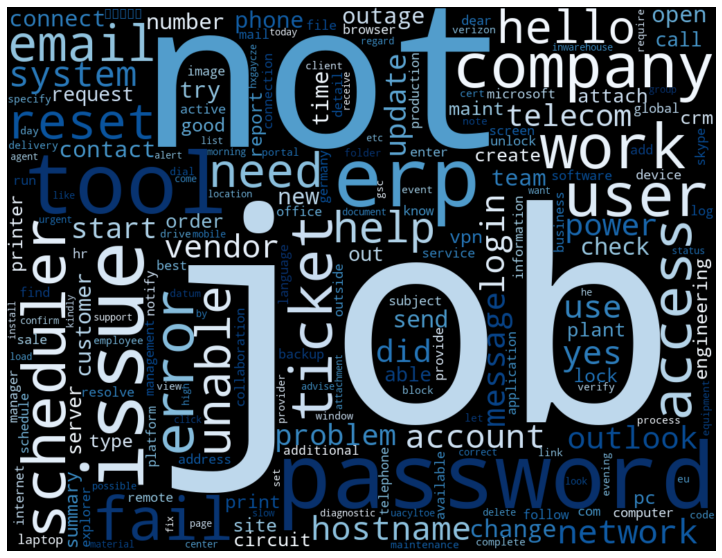

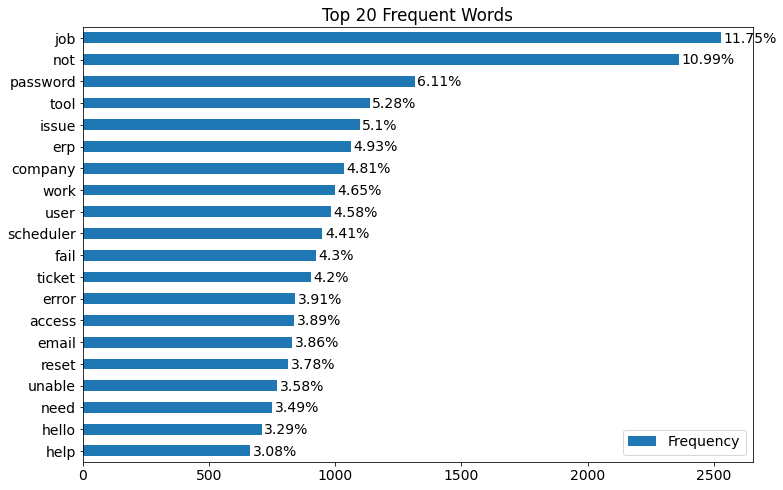

In [44]:
ShowWordCloud(df[Description])

### Remove Non-English Words

In [45]:
wrd = []
def GetNonEnglishWords(sent):  
  for w in nltk.wordpunct_tokenize(sent):
    w = w.lower()
    if w in all_words or not w.isalpha():
      continue
    else:
      wrd.append(w)

df[Description].apply(lambda x: GetNonEnglishWords(x))
import collections
c = collections.Counter(wrd)
tmp = pd.DataFrame.from_dict(c, orient='index').reset_index()
tmp = tmp.rename(columns={'index':'word', 0:'count'})
tmp.to_excel("Words.xlsx")

In [46]:
from collections import OrderedDict 

def RemoveNonEnglishWords(sent):
  wrds=[]
  for w in nltk.wordpunct_tokenize(sent):
    w = w.lower()  
    if len(w) > 1 and (w in all_words or w in exclusion_list or not w.isalpha()):
      wrds.append(w)
  return ' '.join(OrderedDict().fromkeys(wrds))

In [47]:
df["Clean Description"] = df[Description].apply(lambda x: RemoveNonEnglishWords(x))

# Copying the data frame with English Description
english_df = df.copy()
df.to_excel('English-Data.xlsx', index=False)
%cp /content/English-Data.xlsx /content/drive/My\ Drive/GL/Capstone

# Pick required column & Rename to Description for further processing
df = df[['Clean Description', AssignmentGroup]]
df.rename(columns={"Clean Description": Description}, inplace=True)

english_df.head(25)

Description  ...                                  Clean Description
0   login issue verify user detail employee manage...  ...  login issue verify user detail employee manage...
1   outlook hello team meeting skype meeting etc n...  ...  outlook hello team meeting skype etc not appea...
2                              not login vpn not best  ...                                 not login vpn best
3                          unable access hr tool page  ...                         unable access hr tool page
4                                         skype error  ...                                        skype error
5                 unable login engineering tool skype  ...                unable login engineering tool skype
6   event critical hostname company com value moun...  ...  event critical hostname company com value thre...
7   ticket employment status new non employee ente...  ...  ticket employment status new non employee ente...
8                        unable disable addin outlook  ...                       unable disable addin outlook
9                               ticket update inplant  ...                              ticket update inplant
10  engineering tool not connect unable submit report  ...  engineering tool not connect unable submit report
11               hr tool site not load page correctly  ...               hr tool site not load page correctly
12               unable login hr tool xwbesorf  cards  ...                         unable login hr tool cards
13                           user want reset password  ...                           user want reset password
14                                unable open payslip  ...                                unable open payslip
15                              ticket update inplant  ...                              ticket update inplant
16  unable login company vpn website try open new ...  ...  unable login company vpn website try open new ...
17                       unlocking pc screen not come  ...                       unlocking pc screen not come
18                                   erp account lock  ...                                   erp account lock
19                                    unable sign vpn  ...                                    unable sign vpn
20                               unable check payslip  ...                               unable check payslip
21  vpn issue hello helpdesk  not able connect hom...  ...  vpn issue hello not able connect home office c...
22                                 unable connect vpn  ...                                 unable connect vpn
23                      user call vendor phone number  ...                      user call vendor phone number
24  vpn not work hellobee  able connect company ne...  ...  vpn not work able connect company network chec...

[25 rows x 4 columns]

In [48]:
df = english_df
df = df[['Clean Description', AssignmentGroup]]
df.rename(columns={"Clean Description": Description}, inplace=True)

### Remove Redundant Text

In [49]:
temp_df = df[df[AssignmentGroup] == 'GRP_0'].reset_index(drop=True)
print("Shape of Group 0 dataset:", temp_df.shape)

Shape of Group 0 dataset: (3428, 2)


In [50]:
def UpdateDescription(frame, idxs, value):
  for idx in idxs:
    frame[Description][idx] = value
  return frame

def ReplaceRedundantData(frame, filterlist, matchlist, replacetext):
  res = frame
  if len(filterlist) > 0:
    filterpattern = '|'.join(filterlist)
    idxs = frame[frame[Description].str.contains(filterpattern)].index
    res = UpdateDescription(frame, idxs, replacetext)
  if len(matchlist) > 0:
    matchpattern = '|'.join(matchlist)
    idxs = frame[frame[Description].str.fullmatch(matchpattern)].index
    res = UpdateDescription(frame, idxs, replacetext)
  return res

In [51]:
temp_df = ReplaceRedundantData(temp_df, 
                               ['ad account lock', 'ad password reset', 'ad lock password', 'account lock ad', 'unlock ad account'],
                               ['ad lock', 'password reset ad', 'active directory lock'], 
                               'ad active directory account lock need unlock password reset')
temp_df = ReplaceRedundantData(temp_df, 
                               ['account lock erp', 'account unlock erp', 'erp account lock', 'erp account lockout', 'erp account unlock', 'erp lock' ],
                               [], 'erp account lock need unlock windows')
temp_df = ReplaceRedundantData(temp_df, 
                               ['erp password block', 'erp password forget', 'erp password lock', 'erp password reset' ], \
                               [], 'erp password reset lock request need unlock windows user')
temp_df = ReplaceRedundantData(temp_df, 
                               ['account disable', 'account unlock request', 'account lock issue', 'account lock hello team', 'account lock frequently', \
                                'frequent account lockout', 'frequent account lock user', 'account lock release'], \
                               ['account lockout', 'account unlock', 'account lock', 'account unlock not', 'account lock unlock', 'account lock window', 'frequent account lock'],
                               'account lock need unlock windows computer')
temp_df = ReplaceRedundantData(temp_df, ['account lock password', 'account password summary'], [], 'account lock password reset expire')
temp_df = ReplaceRedundantData(temp_df, ['blank call'], [], 'blank gso call loud noise disconnect')
temp_df = ReplaceRedundantData(temp_df, ['call check account'], [], 'call check account disable active')
temp_df = ReplaceRedundantData(temp_df, ['ie browser issue'], ['browser issue'], 'ie browser issue website not load')
temp_df = ReplaceRedundantData(temp_df, ['audio not work', 'audio issue', 'sound issue'], ['sound not work'], \
                               'audio laptop not work pc tablet sound driver issue skype service call contact teamviewer connect setting')
temp_df = ReplaceRedundantData(temp_df, ['attendance tool password', 'attendance tool login'], [], 'attendance tool password forget reset need help')
temp_df = ReplaceRedundantData(temp_df, ['add member', 'add share'], [], 'add member share distribution mailbox group outlook')
temp_df = ReplaceRedundantData(temp_df, ['reset password erp production'], [], 'reset password erp production unlock unable lock hcm login account user')
temp_df = ReplaceRedundantData(temp_df, [], 
                               ['collaboration platform not', 'collaboration platform not open', 'collaboration platform not available internet access', \
                                'browser issue collaboration platform not load', 'collaboration platform issue', 'collaboration platform query', \
                                'collaboration platform site not open'],
                               'collaboration platform not available open load browser internet issue query')
temp_df = ReplaceRedundantData(temp_df, ['email not open desktop', 'email not update'], 
                               ['email morning kind', 'email not work'], 'email outlook not work')
temp_df = ReplaceRedundantData(temp_df, [], 
                               ['engineering tool loin', 'engineering tool not open', 'engineering tool not work', 'engineering tool page not open'],
                               'engineering tool not open work')
temp_df = ReplaceRedundantData(temp_df, ['mobile device activation', 'need activate new'], [], 'mobile device activation request new phone company personal')
temp_df = ReplaceRedundantData(temp_df, ['ms crm dynamics', 'ms dynamics'], ['ms outlook issue crm dynamics', 'outlook issue ms crm dynamics'], 'ms crm dynamics outlook issue error')
temp_df = ReplaceRedundantData(temp_df, ['ms office installation'], [], 'ms office installation')
temp_df = ReplaceRedundantData(temp_df, ['need change password'], ['need help password reset', 'need password reset'], 'need help password change reset')
temp_df = ReplaceRedundantData(temp_df, ['need help change password management', 'need help reset password management'], [], 'need help change reset password management')
temp_df = ReplaceRedundantData(temp_df, ['outlook freeze', 'outlook not respond crm'], 
                               ['outlook freezes freeze', 'outlook freezing issue', 'outlook hangs not open', 'outlook issue not load'], 'outlook freeze crm hangs not respond')
temp_df = ReplaceRedundantData(temp_df, ['outlook not connect'], 
                               ['outlook not function', 'outlook not launch', 'outlook not open', 'outlook not load', 'outlook not start'], 'outlook not open load connect')
temp_df = ReplaceRedundantData(temp_df, ['password activate', 'pass word reset', 'reset user password'], 
                               ['password reset expire', 'reset password account', 'reset password user', 'reset password userid'], 'password activate reset expire')
temp_df = ReplaceRedundantData(temp_df, ['password management tool manager'], [], 'password management tool manager unable reset help query')
temp_df = ReplaceRedundantData(temp_df, ['reset microsoft online services password'], [], 'request reset microsoft online services password')
temp_df = ReplaceRedundantData(temp_df, ['request erp password'], [], 'request erp password')
temp_df = ReplaceRedundantData(temp_df, ['request erp user'], [], 'request erp user account password')
temp_df = ReplaceRedundantData(temp_df, ['request passoword erp qa'], [], 'request passoword erp qa hcm login')
temp_df = ReplaceRedundantData(temp_df, ['reset passoword window', 'reset windows password'], [], 'request passoword windows login unlock')
temp_df = ReplaceRedundantData(temp_df, ['supply chain software'], [], 'supply chain software password reset unable access')
temp_df = ReplaceRedundantData(temp_df, ['survey related ticket'], [], 'survey related ticket not work')
temp_df = ReplaceRedundantData(temp_df, ['unable access email'], [], 'unable access email outlook')
temp_df = ReplaceRedundantData(temp_df, ['urgent help require outlook crm mfg'], [], 'urgent help require outlook crm mfg issue')
temp_df = ReplaceRedundantData(temp_df, ['windows account'], [], 'windows account unlock reset password')
temp_df = ReplaceRedundantData(temp_df, ['windows password'], [], 'windows password expire reset request management tool')

# Drop Duplicate rows from data
temp_df = temp_df.drop_duplicates([Description, AssignmentGroup])
print('Shape of GRP_0 data', temp_df.shape)

Shape of GRP_0 data (2699, 2)


In [52]:
df = pd.concat([temp_df, df[df[AssignmentGroup] != 'GRP_0']])
df.reset_index(inplace=True, drop=True)
print('Shape of complete data', df.shape)

Shape of complete data (7176, 2)


### Stop Word Removal Again

In [53]:
df["Processed Description"] = df[Description].apply(lambda x: RemoveStopWords(x))

# Copying the data frame with Lemmatized Description
processed_df = df.copy()
df.to_excel('Final-Stop-Word-Removed-Data.xlsx', index=False)

# Pick required column & Rename to Description for further processing
df = df[['Processed Description', AssignmentGroup]]
df.rename(columns={"Processed Description": Description}, inplace=True)

processed_df.head(25)

Description  ...                              Processed Description
0   login issue verify user detail employee manage...  ...  login issue verify user detail employee manage...
1   outlook hello team meeting skype etc not appea...  ...  outlook hello team meeting skype etc not appea...
2                                  not login vpn best  ...                                 not login vpn best
3                          unable access hr tool page  ...                         unable access hr tool page
4                                         skype error  ...                                        skype error
5                 unable login engineering tool skype  ...                unable login engineering tool skype
6   ticket employment status new non employee ente...  ...  ticket employment status new non employee ente...
7                        unable disable addin outlook  ...                       unable disable addin outlook
8                               ticket update inplant  ...                              ticket update inplant
9   engineering tool not connect unable submit report  ...  engineering tool not connect unable submit report
10               hr tool site not load page correctly  ...               hr tool site not load page correctly
11                         unable login hr tool cards  ...                         unable login hr tool cards
12                           user want reset password  ...                           user want reset password
13                                unable open payslip  ...                                unable open payslip
14  unable login company vpn website try open new ...  ...  unable login company vpn website try open new ...
15               erp account lock need unlock windows  ...               erp account lock need unlock windows
16                                    unable sign vpn  ...                                    unable sign vpn
17                               unable check payslip  ...                               unable check payslip
18  vpn issue hello not able connect home office c...  ...  vpn issue hello not able connect home office c...
19                                 unable connect vpn  ...                                 unable connect vpn
20                      user call vendor phone number  ...                      user call vendor phone number
21  vpn not work able connect company network chec...  ...  vpn not work able connect company network chec...
22  erp password reset lock request need unlock wi...  ...  erp password reset lock request need unlock wi...
23                 unable login hr tool check payslip  ...                 unable login hr tool check payslip
24                                   account lock out  ...                                   account lock out

[25 rows x 3 columns]

In [54]:
df = df[df[Description].str.split().str.len() > 2]
df.shape

(6877, 2)

### Duplicate/Missing Value Check

In [55]:
duplicate_df = df[df.duplicated()]
duplicate_df[AssignmentGroup].value_counts()

GRP_8     357
GRP_9     181
GRP_6     110
GRP_5      81
GRP_10     58
GRP_17     40
GRP_12     21
GRP_24     14
GRP_2      14
MISC       12
GRP_45      6
GRP_4       6
GRP_47      5
GRP_0       4
GRP_18      3
GRP_1       3
GRP_13      3
GRP_23      1
GRP_7       1
GRP_62      1
GRP_14      1
GRP_41      1
Name: Assignment group, dtype: int64

In [56]:
df = df.drop_duplicates([Description, AssignmentGroup])
print("Data Shape after dropping Duplicate Values:", df.shape)

Data Shape after dropping Duplicate Values: (5954, 2)


In [57]:
df = df.dropna(how='any',axis=0)
print("Data Shape after dropping Missing Values:", df.shape)
df.isnull().sum()

Data Shape after dropping Missing Values: (5954, 2)


Description         0
Assignment group    0
dtype: int64

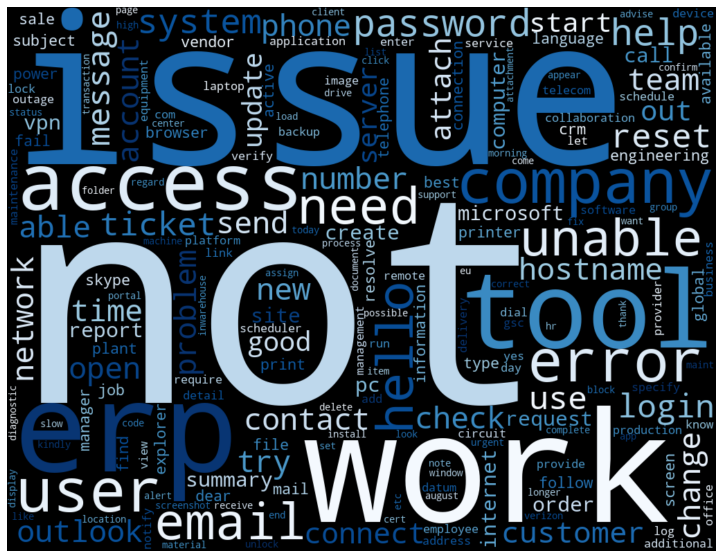

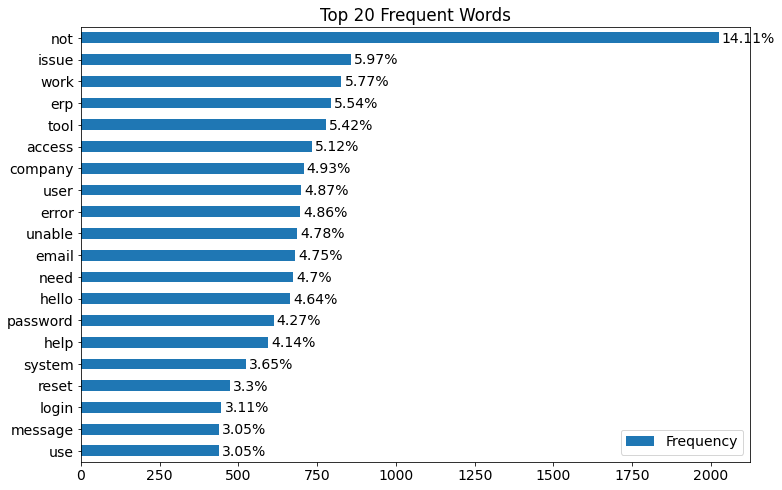

In [58]:
ShowWordCloud(df[Description])

Total no. of unique values are 41


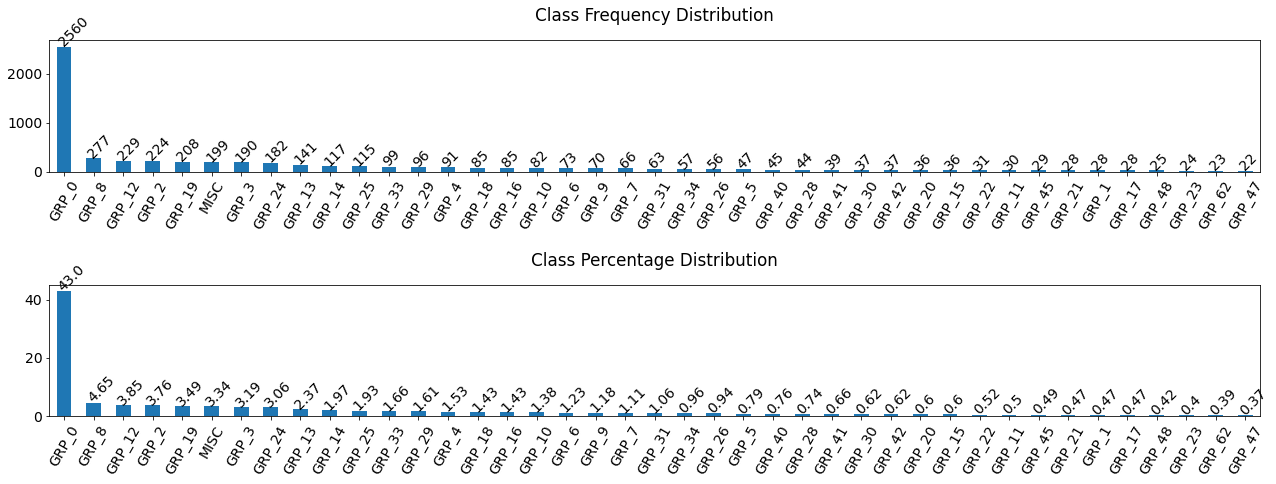

In [59]:
MultiClassDataDistribution(df[AssignmentGroup])

In [60]:
# Final Data after Text Pre-Processing
final_df = df.copy()
X = df[Description]
y = df[AssignmentGroup]
df.info()
final_df.to_excel('Final-Processed-Data.xlsx', index=False)
%cp /content/Final-Processed-Data.xlsx /content/drive/My\ Drive/GL/Capstone

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5954 entries, 0 to 7175
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Description       5954 non-null   object
 1   Assignment group  5954 non-null   object
dtypes: object(2)
memory usage: 139.5+ KB


**Text Pre-Processing task is completed. Now let us start with Data Resampling to deal with the imbalance in the dataset**

### Logical Split of Dataset
We are going to perform 2 steps to logically split the data for further processing
1.   Add new column i.e. Is_GRP_0 to indicate whether the row belongs to GRP_0 or not. Since GRP_0 is major contributor in the data we are performing this step.
2.   Create separate dataset of all non GRP_0 assignment groups

So, now we have 2 separate datasets on which the model will execute and the prediction will be done. 

The Hypertuned Model will evaluate the first dataset i.e. GRP_0 vs Others and predict the output.
*   Prediction = 1 i.e. GRP_0 -> Processing ends we have got the assignment group
*   Prediction = 0 i.e. Others -> Continue processing with second dataset having data of other groups and find the actual assignment group


In [61]:
df_others = df[df[AssignmentGroup] != 'GRP_0']
print("Other Groups Dataset Shape:", df_others.shape)

Other Groups Dataset Shape: (3394, 2)


In [62]:
IsGroup0 = 'Is_GRP_0'
df[IsGroup0] = df[AssignmentGroup].apply(lambda x: 'GRP_0' if x == 'GRP_0' else 'Others')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5954 entries, 0 to 7175
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Description       5954 non-null   object
 1   Assignment group  5954 non-null   object
 2   Is_GRP_0          5954 non-null   object
dtypes: object(3)
memory usage: 186.1+ KB


Total no. of unique values are 2


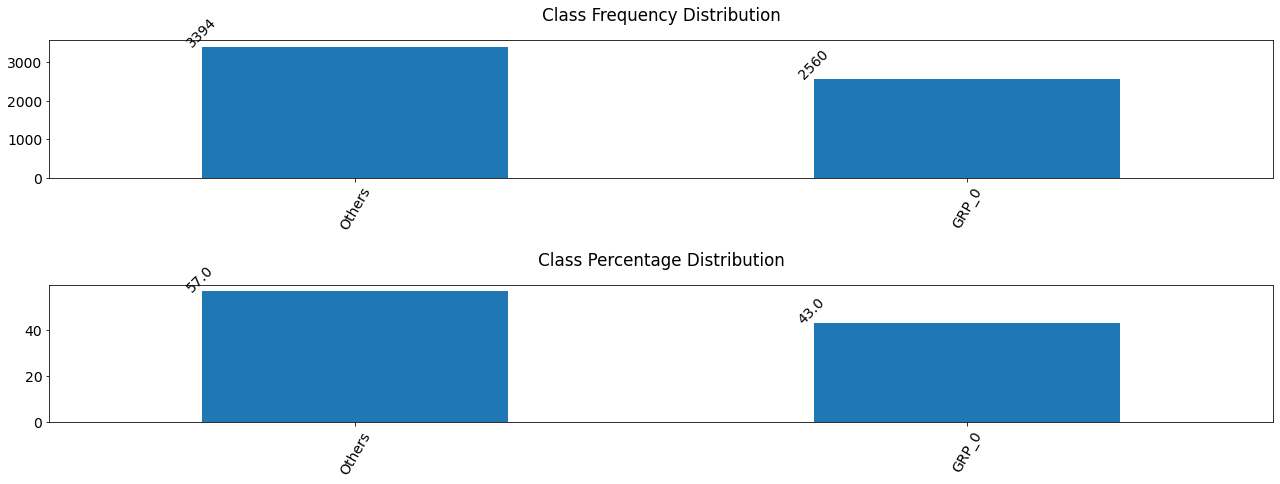

In [63]:
MultiClassDataDistribution(df[IsGroup0])

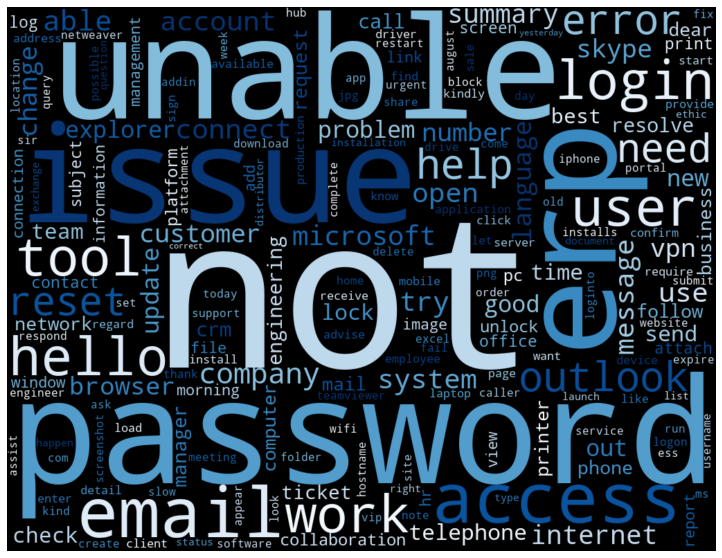

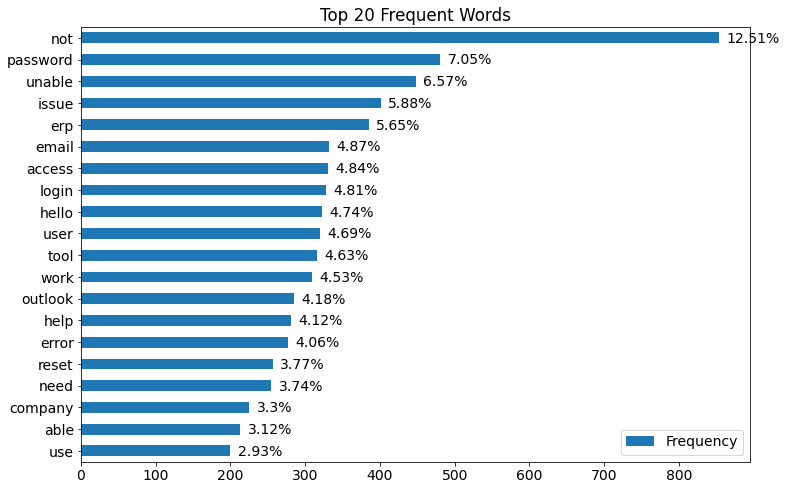

In [64]:
df_group0 = df[df[IsGroup0] == 'GRP_0']
ShowWordCloud(df_group0[Description])

Total no. of unique values are 40


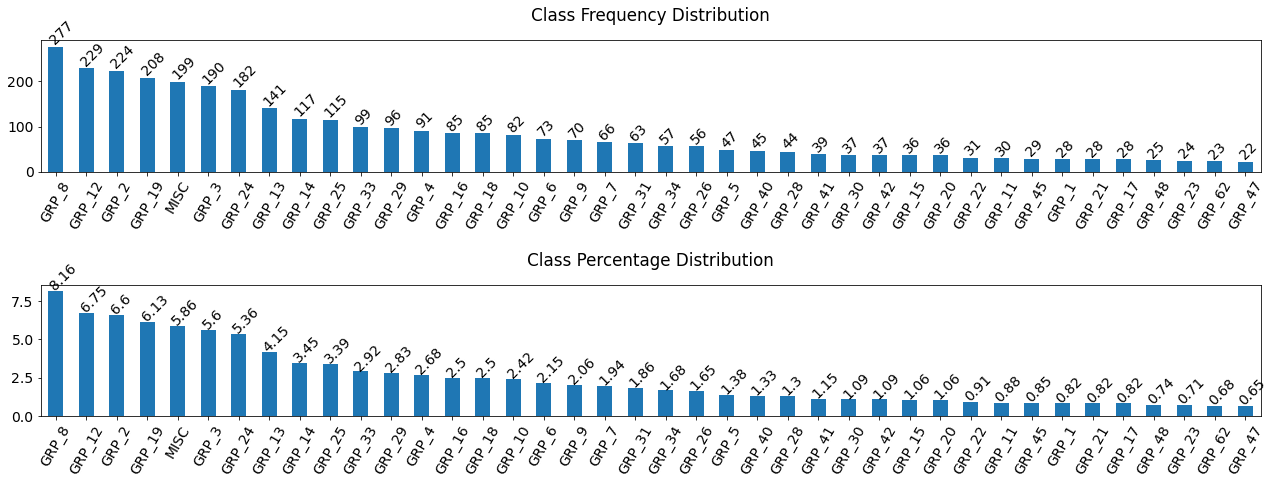

In [65]:
MultiClassDataDistribution(df_others[AssignmentGroup])

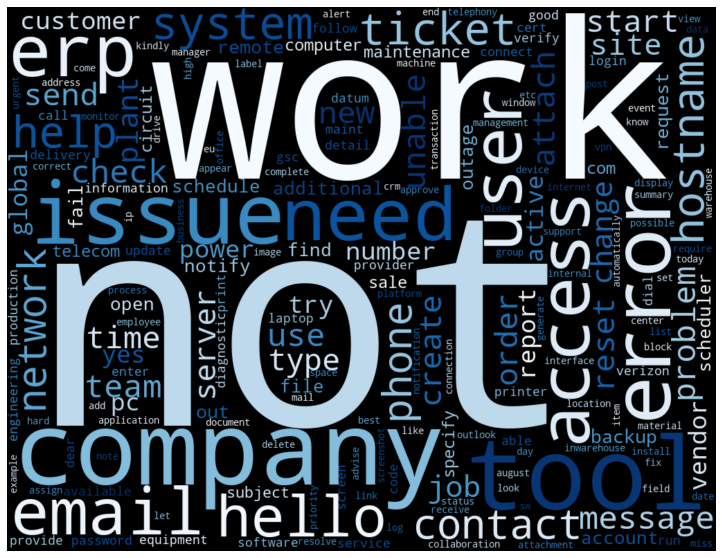

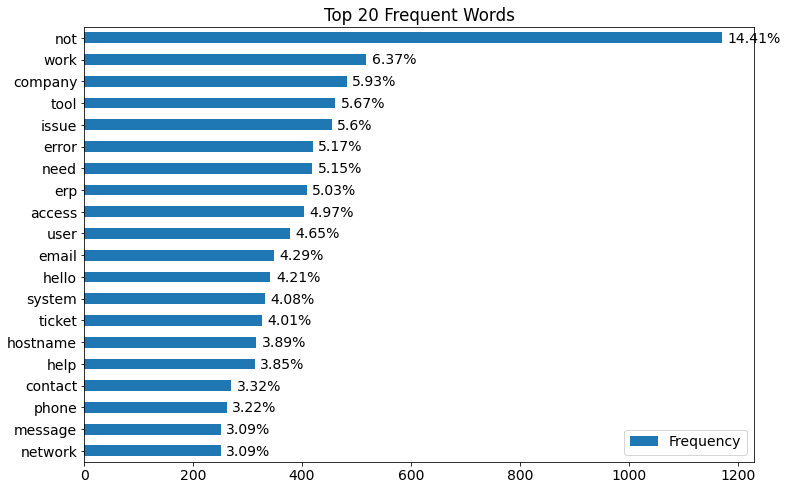

In [66]:
ShowWordCloud(df_others[Description])

### Data Resampling
The Logical Split has facilitated us with segregation of data but still the data is imbalanced. The second dataset i.e. Other groups one is very skewed and we need to perform resampling of the data.
We are going to perform the following steps
  *   Over Sample first dataset so that the count of GRP_0 as well as non GRP_0 matches.
  *   Over Sample second dataset i.e. the other groups dataset based on maximum value count of a group within that dataset.

In [67]:
from sklearn.utils import resample

def ResampleDataset(ds, size, col):
  ds_sampled = pd.DataFrame(columns=[Description, col])
  for grp in ds[col].unique():
    grp_df = ds[ds[col] == grp]
    sampled = resample(grp_df, replace=True, n_samples=int(size), random_state=RANDOM_STATE)
    ds_sampled = ds_sampled.append(sampled)
  ds_sampled.reset_index(inplace=True)
  ds_sampled.drop(columns=['index'], inplace=True)
  return ds_sampled

# Over Sampling the Other groups dataset
size = df_others[AssignmentGroup].value_counts().max()
df_other_sampled = ResampleDataset(df_others, size, AssignmentGroup)

# Over Sampling the GRP_0 dataset
size = df[IsGroup0].value_counts().max()
df = ResampleDataset(df, size, IsGroup0)

#### Class Distribution of Other Groups Dataset

Total no. of unique values are 40


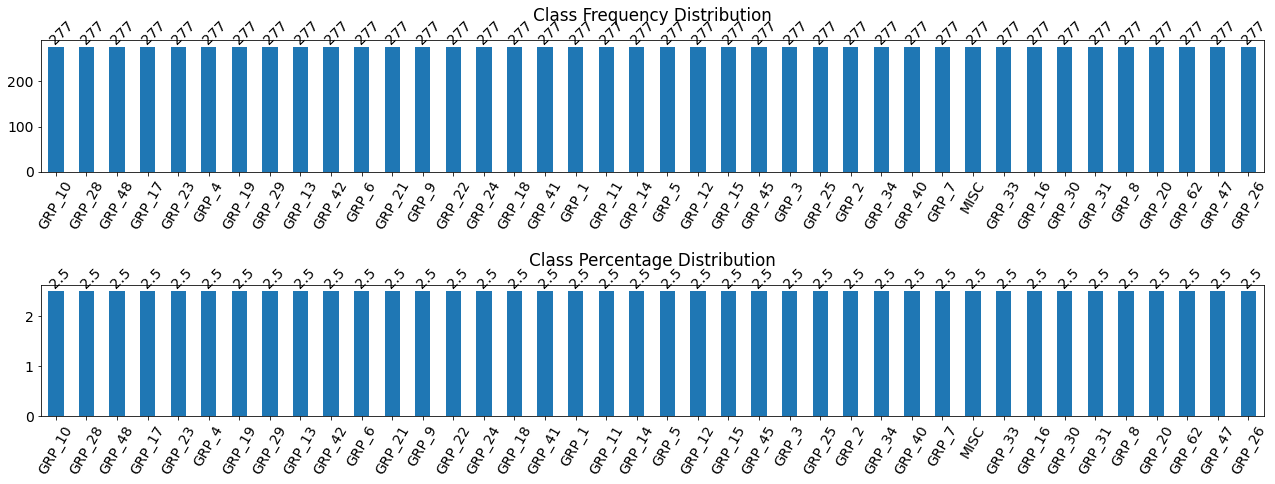

In [68]:
MultiClassDataDistribution(df_other_sampled[AssignmentGroup])

**In the other group dataset, GRP_8 has the maximum count, we will over sample the remaining groups to this count.**

Total no. of unique values are 2


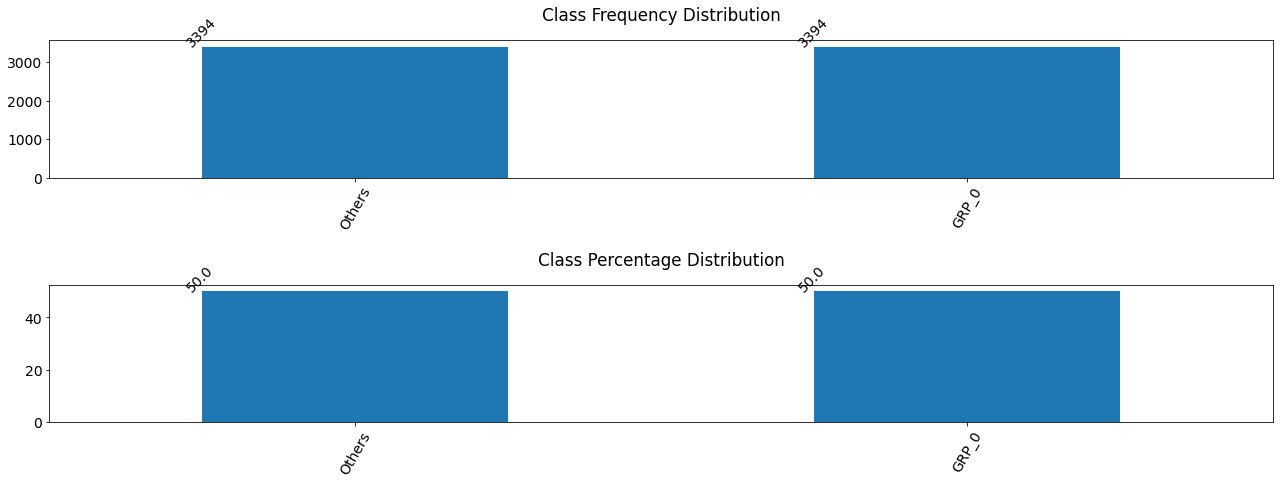

In [69]:
MultiClassDataDistribution(df[IsGroup0])

In [70]:
# Final Data after adding derived column Is_GRP_0
# This data wil be used to identify whether Assignment group is GRP_0 or Others
final_df_group0 = df.copy()
X = df[Description]
y = df[IsGroup0]
df.info()
final_df_group0.to_excel('Group-0-Data.xlsx', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6788 entries, 0 to 6787
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Description       6788 non-null   object
 1   Is_GRP_0          6788 non-null   object
 2   Assignment group  6788 non-null   object
dtypes: object(3)
memory usage: 159.2+ KB


In [71]:
# Final Data of Other GRP after removing GRP_0
final_df_others = df_other_sampled.copy()
Xs = df_other_sampled[Description]
ys = df_other_sampled[AssignmentGroup]
df_other_sampled.info()
final_df_others.to_excel('Group-Others-Data.xlsx', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11080 entries, 0 to 11079
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Description       11080 non-null  object
 1   Assignment group  11080 non-null  object
dtypes: object(2)
memory usage: 173.2+ KB


### Split Train-Test Data
We will run over models through both the original as well as the sampled dataset & try to find out which one gives good performance

In [72]:
from sklearn.model_selection import train_test_split

def SplitData(feature, label, size):
  xtr, xtt, ytr, ytt = train_test_split(feature, label, test_size = size, stratify = label, shuffle=True)
  print("Training Data Shape (X)", xtr.shape)
  print("Training Data Shape (y)", ytr.shape)
  print("Testing Data Shape (X)", xtt.shape)
  print("Testing Data Shape (y)", ytt.shape)
  return xtr, xtt, ytr, ytt

def SplitDataset(feature, label, validationSetRequired = False):  
  xtr, xtt, ytr, ytt = SplitData(feature, label, 0.3)
  if validationSetRequired:
    print("\nPost Validation Split ->")
    xtr, xvl, ytr, yvl = SplitData(xtr, ytr, 0.2)
    return xtr, xtt, ytr, ytt, xvl, yvl
  return xtr, xtt, ytr, ytt

In order to avoid variations in the distributions while splitting Training & Testing dataset we have performed Stratification. This ensures that the datasets are not skewed and there is proper distribution of classes, in our case it is the Assignment Groups 

## Machine Learning - Model Building

In [73]:
# Group 0 Dataset
print("Group 0 Data Split ->")
X_train, X_test, y_train, y_test = SplitDataset(X, y, validationSetRequired = False)

# Other Group Dataset
print("\Other Group Data Split ->")
Xs_train, Xs_test, ys_train, ys_test = SplitDataset(Xs, ys, validationSetRequired = False)

Group 0 Data Split ->
Training Data Shape (X) (4751,)
Training Data Shape (y) (4751,)
Testing Data Shape (X) (2037,)
Testing Data Shape (y) (2037,)
\Other Group Data Split ->
Training Data Shape (X) (7756,)
Training Data Shape (y) (7756,)
Testing Data Shape (X) (3324,)
Testing Data Shape (y) (3324,)


#### Training Class Distribution

Class Distribution of the Training set from Group 0 Data
Total no. of unique values are 2


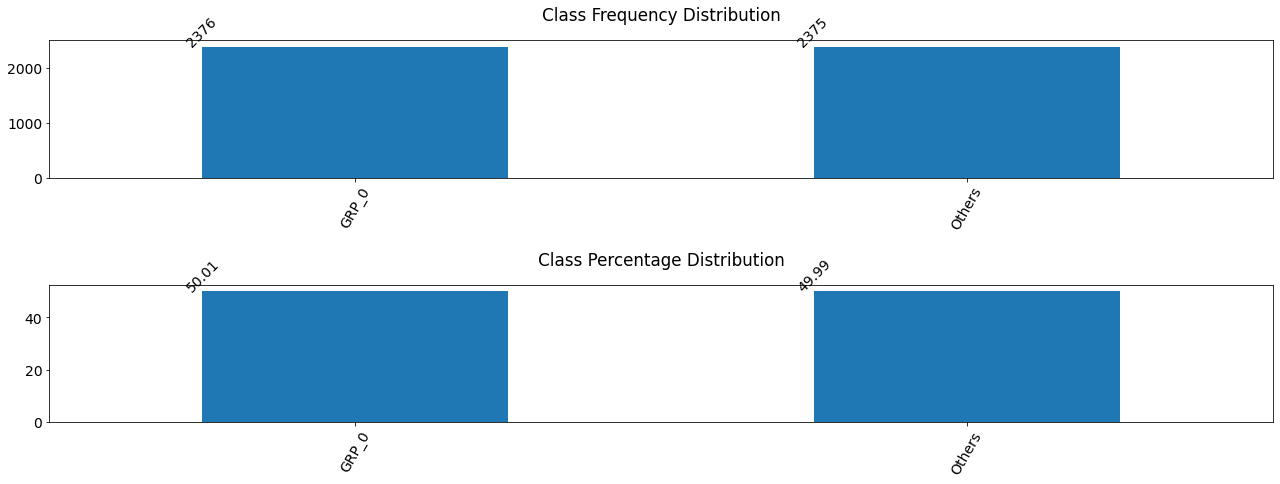

Class Distribution of the Training set from Other Group Data
Total no. of unique values are 40


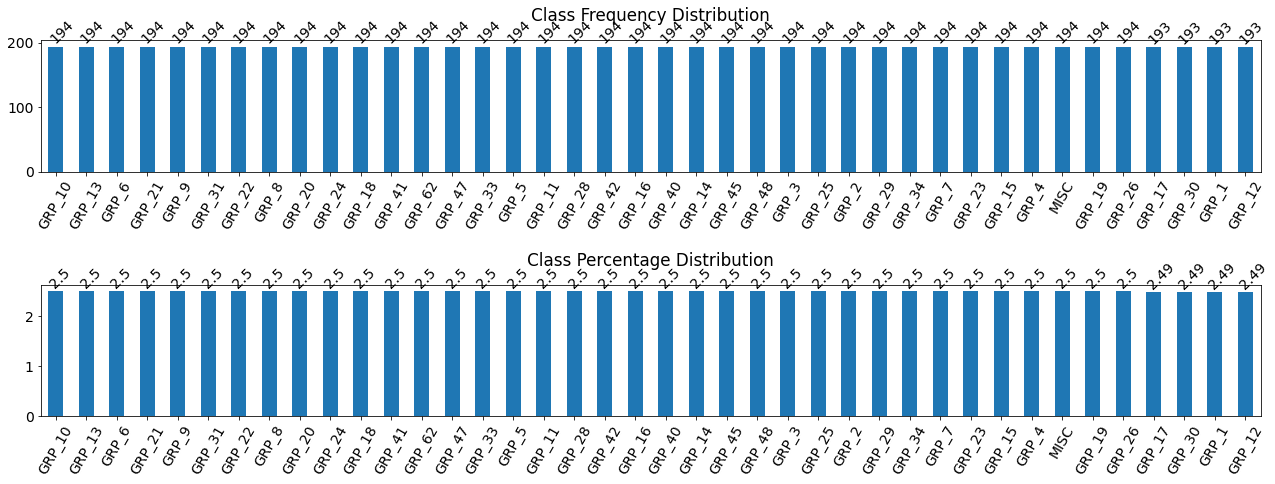

In [74]:
print("Class Distribution of the Training set from Group 0 Data")
MultiClassDataDistribution(y_train)
print("Class Distribution of the Training set from Other Group Data")
MultiClassDataDistribution(ys_train)

#### Testing Class Distribution

Class Distribution of the Testing set from Group 0 Data
Total no. of unique values are 2


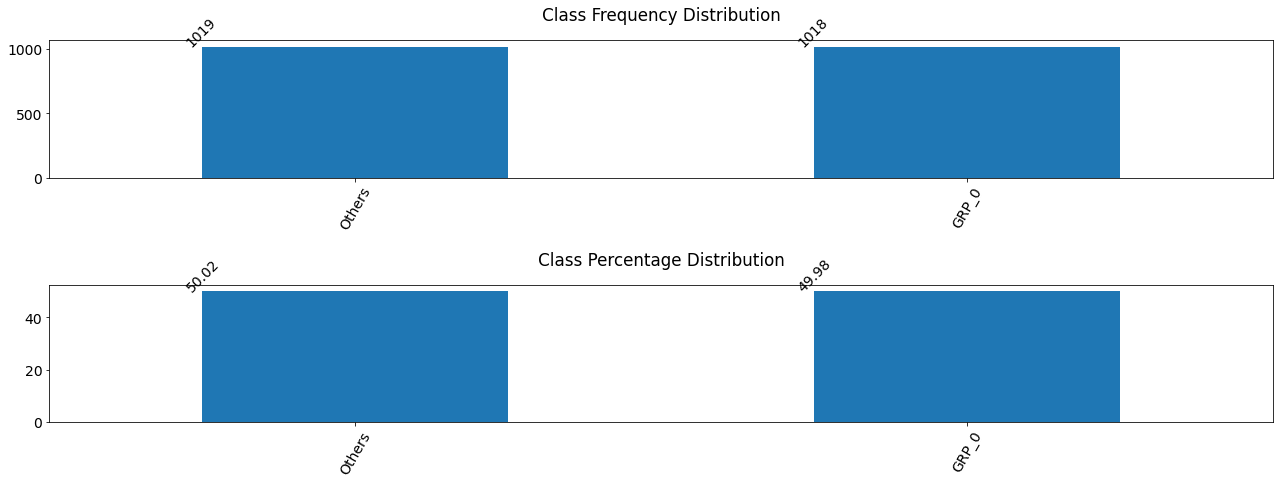

Class Distribution of the Testing set from Other Group Data
Total no. of unique values are 40


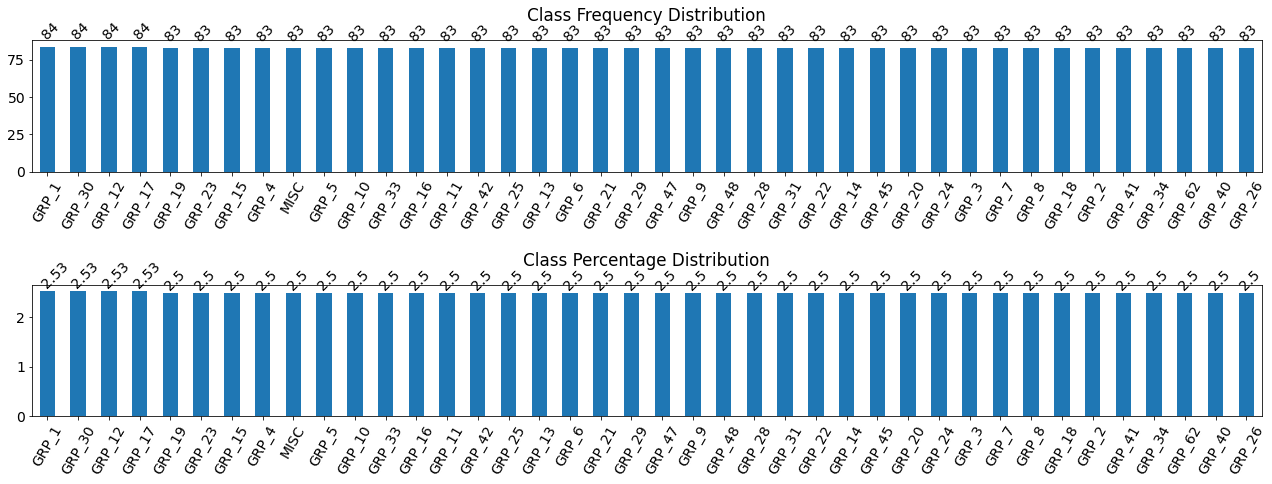

In [75]:
print("Class Distribution of the Testing set from Group 0 Data")
MultiClassDataDistribution(y_test)
print("Class Distribution of the Testing set from Other Group Data")
MultiClassDataDistribution(ys_test)

**The training and testing class distribution of the sampled dataset looks more uniform then the original dataset.**

### TF-IDF Vectorizer & Word Vocabulary

In [76]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

def TdIdfVectorizer(train, test, fname):
  vectorizer = TfidfVectorizer(ngram_range=(1,3))
  vectorizer.fit(train)
  num_features = len(vectorizer.get_feature_names())
  print("Number of Features:", num_features)

  tr = vectorizer.transform(train)
  tt = vectorizer.transform(test)
  wrds = len(vectorizer.vocabulary_)
  print("Training Data Shape:", tr.shape)
  print("Testing Data Shape:", tt.shape)
  print("Total number of words in the vocabulary is", wrds)

  filename = fname + '-vectorizer.pkl'
  pickle.dump(vectorizer, open(filename, 'wb'))
  torch.save(vectorizer, filePath + filename)
  print("Vectorizer is saved as {0} \n".format(filename))
  return tr, tt, wrds

print("Vectorization details of Group 0 Dataset ->")
Xtrain_tfidf, Xtest_tfidf, WORDS = TdIdfVectorizer(X_train, X_test, 'grp0')

print("\nVectorization details of Other Group Dataset ->")
Xstrain_tfidf, Xstest_tfidf, WORDS_SAMPLED = TdIdfVectorizer(Xs_train, Xs_test, 'others')

Vectorization details of Group 0 Dataset ->
Number of Features: 54100
Training Data Shape: (4751, 54100)
Testing Data Shape: (2037, 54100)
Total number of words in the vocabulary is 54100
Vectorizer is saved as grp0-vectorizer.pkl 


Vectorization details of Other Group Dataset ->
Number of Features: 53648
Training Data Shape: (7756, 53648)
Testing Data Shape: (3324, 53648)
Total number of words in the vocabulary is 53648
Vectorizer is saved as others-vectorizer.pkl 



### Label Encoding
Need to encode the Target column classes i.e. Assignment Groups for model building

In [77]:
from sklearn.preprocessing import LabelEncoder
import pickle

def LabelEncoding(train, test, fname):
  enc = LabelEncoder()
  enc.fit(train)

  tr = enc.transform(train)
  tt = enc.transform(test)
  
  filename = fname + '-encoder.pkl'
  pickle.dump(enc, open(filename, 'wb'))
  torch.save(enc, filePath + filename)
  print("Label Encoder is saved as {0} \n".format(filename))
  return tr, tt

ytrain_enc, ytest_enc = LabelEncoding(y_train, y_test, 'grp0')
ystrain_enc, ystest_enc = LabelEncoding(ys_train, ys_test, 'others')

Label Encoder is saved as grp0-encoder.pkl 

Label Encoder is saved as others-encoder.pkl 



### ML Models

In [78]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, LeaveOneOut

import time
import pickle

df_ML_results = pd.DataFrame(columns=['Precision Score', 'Recall Score', 'Training Score', 'Testing Score', 'KFold CV', \
                                        'F1 Score', 'Accuracy Score', 'Execution Time'], 
                             index=['Logistic Regression', 'K-Nearest Neighbors', 'Support Vector Machine', 'Naive Bayes', \
                                    'Decision Trees', 'Random Forest', 'Bagging', 'Gradient Boosting', 'XG Boosting']) 

#### Common Methods for all ML Models

In [79]:
def KFoldCrossValidation (model):
  kfold = StratifiedKFold(shuffle=True, random_state=RANDOM_STATE, n_splits=5)
  results = cross_val_score(model, Xtrain, ytrain, cv=kfold, scoring='accuracy')
  mean, std = results.mean(), results.std()
  print("Cross Validation Test Accuracy:", mean * 100)
  return mean * 100

def LOOCrossValidation (model):
  loocv = LeaveOneOut()
  results = cross_val_score(model, Xtrain, ytrain, cv=loocv, scoring='accuracy')
  mean, std = results.mean(), results.std()
  return mean * 100

def SearchCV(cvtype, mdl, prms):
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
  if cvtype=='grid':
    cv = GridSearchCV(mdl, prms, n_jobs = -1, verbose=3, cv=kfold)
  elif cvtype=='random':
    cv = RandomizedSearchCV(estimator = mdl, param_distributions = prms, verbose=3, n_jobs = -1, n_iter = 30, cv=kfold)
  
  cv.fit(Xtrain, ytrain)
  return cv.best_score_, cv.best_params_

In [80]:
START_TIME = time.time()

def FitModel(mdl):
  mdl.fit(Xtrain, ytrain)
  train = mdl.score(Xtrain, ytrain)
  test = mdl.score(Xtest, ytest)  
  print("Training Data Score: {0}".format(train))
  print("Testing Data Score : {0}".format(test))

#Function to execute the model passed as an argument
def ExecuteModel(model, tuningFunction = None):
  global START_TIME  
  m=model
  if tuningFunction is None:
    kmean = KFoldCrossValidation(model)
    START_TIME = time.time()
    FitModel(m)
    return m, kmean
  FitModel(m)
  print("--------------------Hyper Paramater tuning started--------------------")
  m, scr = tuningFunction(m)
  return m, scr * 100

#Function to print the Final Results of the model
def CaptureScores(model, kmean, label, fname):
  pred = model.predict(Xtest)
  acc = accuracy_score(ytest, pred) * 100
  pr = precision_score(ytest, pred, average='weighted') * 100
  rl = recall_score(ytest, pred, average='weighted') * 100
  f1 = f1_score(ytest, pred, average='weighted') * 100
  tr = model.score(Xtrain, ytrain) * 100
  tt = model.score(Xtest, ytest) * 100
  endtime = (time.time() - START_TIME)

  df_ML_results.at[label, 'Accuracy Score'] = acc 
  df_ML_results.at[label, 'Precision Score'] = pr 
  df_ML_results.at[label, 'Recall Score'] = rl
  df_ML_results.at[label, 'F1 Score'] = f1
  df_ML_results.at[label, 'Training Score'] = tr
  df_ML_results.at[label, 'Testing Score'] = tt
  df_ML_results.at[label, 'KFold CV'] = kmean
  # df_ML_results.at[label, 'LeaveOneOut CV'] = lmean
  df_ML_results.at[label, 'Execution Time'] = endtime

  x = PrettyTable()
  x.field_names = ["Metrics", "Results"]   
  x.add_row(["Accuracy Score", acc])
  x.add_row(["Precision Score", pr])
  x.add_row(["Recall Score", rl])
  x.add_row(["F1 Score", f1])
  x.add_row(["Training Score", tr])
  x.add_row(["Testing Score", tt])
  x.add_row(["KFold CV", kmean])
  # x.add_row(["LeaveOneOut CV", lmean])
  x.add_row(["Execution Time", endtime])
  print(x)

  filename = fname + '.pkl'
  pickle.dump(model, open(filename, 'wb'))  
  torch.save(model, filePath + filename)
  print("Model is saved as {0} \n".format(filename))

def ExecuteAllMLModels(models):
  for name, filename, model, hyptune in models:
    print("{0} - Model Execution Started ------------------------------------------------------------\n".format(name))
    mdl, score = ExecuteModel(model, hyptune)
    CaptureScores(mdl, score, name, filename)

#### Hyper Parameter Tuning Methods

In [81]:
def LogisticRegressionTuneHyperParams(lr):
  # Hyper Parameter
  solvers = ['newton-cg', 'lbfgs']
  # Create regularization penalty space
  penalty = ['l1', 'l2']
  # Create regularization hyperparameter space
  C = [0.1, 1, 10, 100, 1000]
  # Create hyperparameter options
  param = dict(C=C, penalty=penalty, solver=solvers)

  lr_bestScore, lr_bestParam = SearchCV('random', lr, param)
  print("Best Accuracy after Tuning: {0}".format(lr_bestScore))
  print("Best Parameter after Hyper Tuning: {0}".format(lr_bestParam))
  print("--------------------Hyper Paramater tuning complete--------------------") 

  #Creating new model with best Parameters and running on the data again
  global START_TIME
  START_TIME = time.time()
  
  C = lr_bestParam['C']
  penalty = lr_bestParam['penalty']
  sol=lr_bestParam['solver']
  lr = LogisticRegression(C=C, penalty=penalty, solver=sol)
  lr.fit(Xtrain, ytrain)

  return lr, lr_bestScore

def KNNTuneHyperParams(knn):
  knn = KNeighborsClassifier()
  n_neighbors = range(5, 21, 2)
  weights = ['uniform', 'distance']
  metric = ['euclidean', 'manhattan', 'minkowski']
  param = dict(n_neighbors = n_neighbors, weights=weights, metric=metric)

  knn_bestScore, knn_bestParam = SearchCV('random', knn, param)  
  print("Best Accuracy after Tuning: {0}".format(knn_bestScore))
  print("Best Parameter after Hyper Tuning: {0}".format(knn_bestParam))
  print("--------------------Hyper Paramater tuning complete--------------------")
  
  #Creating new model with best Parameters and running on the data again
  global START_TIME
  START_TIME = time.time()
 
  k = knn_bestParam['n_neighbors']
  w = knn_bestParam['weights']
  m = knn_bestParam['metric']
  knn = KNeighborsClassifier(n_neighbors=k, weights=w, metric=m)
  knn.fit(Xtrain, ytrain)

  return knn, knn_bestScore

def SVMTuneHyperParams(svc):
  svc = SVC()
  kernel = ['linear', 'poly', 'rbf']
  Cs = [10, 1.0, 0.1, 100]
  param = dict(kernel = kernel, C = Cs)

  svc_bestScore, svc_bestParam = SearchCV('random', svc, param)
  print("Best Accuracy after Tuning: {0}".format(svc_bestScore))
  print("Best Parameter after Hyper Tuning: {0}".format(svc_bestParam))
  print("--------------------Hyper Paramater tuning complete--------------------")

  #Creating new model with best Parameters and running on the data again
  global START_TIME
  START_TIME = time.time()
 
  k = svc_bestParam['kernel']
  C = svc_bestParam['C']
  svc = SVC(kernel = k, C=C, probability=True)
  svc.fit(Xtrain, ytrain)

  return svc, svc_bestScore

def MultiNBTuneHyperParams(mnb):
  mnb = MultinomialNB()
  alpha = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.5, 2]
  fit = [True, False]
  param = dict(alpha = alpha, fit_prior = fit)

  mnb_bestScore, mnb_bestParam = SearchCV('random', mnb, param)
  print("Best Accuracy after Tuning: {0}".format(mnb_bestScore))
  print("Best Parameter after Hyper Tuning: {0}".format(mnb_bestParam))
  print("--------------------Hyper Paramater tuning complete--------------------")

  #Creating new model with best Parameters and running on the data again
  global START_TIME
  START_TIME = time.time()
 
  a = mnb_bestParam['alpha']
  f = mnb_bestParam['fit_prior']
  mnb = MultinomialNB(alpha = a, fit_prior = f)
  mnb.fit(Xtrain, ytrain)

  return mnb, mnb_bestScore

In [82]:
def DecisionTreesTuneHyperParams(dt):
  dt = DecisionTreeClassifier()
  minSplit = [2, 5, 8, 10, 15]
  criterion = ['gini', 'entropy']
  max_features = [None, 'sqrt', 'log2']
  param = dict(criterion = criterion, min_samples_split = minSplit, max_features=max_features)

  dt_bestScore, dt_bestParam = SearchCV('random', dt, param)
  print("Best Accuracy after Tuning: {0}".format(dt_bestScore))
  print("Best Parameter after Hyper Tuning: {0}".format(dt_bestParam))
  print("--------------------Hyper Paramater tuning complete--------------------") 

  #Creating new model with best Parameters and running on the data again
  global START_TIME
  START_TIME = time.time()
 
  c = dt_bestParam['criterion']
  mss = dt_bestParam['min_samples_split']
  maxf = dt_bestParam['max_features']
  dt = DecisionTreeClassifier(criterion = c, min_samples_split = mss, max_features=maxf)
  dt.fit(Xtrain, ytrain)
   
  return dt, dt_bestScore

def RandomForestTuneHyperParams(rf):
  rf = RandomForestClassifier()
  est = [1000, 1500, 2000]
  minSplit = [2, 5, 15] 
  criterion = ['gini', 'entropy']
  max_features = ['sqrt', 'log2']
  param = dict(n_estimators = est, min_samples_split = minSplit, criterion = criterion, max_features=max_features)

  rf_bestScore, rf_bestParam = SearchCV('random', rf, param)
  print("Best Accuracy after Tuning: {0}".format(rf_bestScore))
  print("Best Parameter after Hyper Tuning: {0}".format(rf_bestParam))
  print("--------------------Hyper Paramater tuning complete--------------------")  
  
  #Creating new model with best Parameters and running on the data again
  global START_TIME
  START_TIME = time.time()
 
  e = rf_bestParam['n_estimators']
  mss = rf_bestParam['min_samples_split']
  c = rf_bestParam['criterion']
  maxf = rf_bestParam['max_features']
  rf = RandomForestClassifier(n_estimators = e, min_samples_split = mss, criterion = c, max_features=maxf)
  rf.fit(Xtrain, ytrain)
  
  return rf, rf_bestScore

def BaggingTuneHyperParams(bg):
  bg = BaggingClassifier()
  est = [10, 100, 500, 1000, 1500]
  param = dict(n_estimators = est)

  bg_bestScore, bg_bestParam = SearchCV('random', bg, param)
  print("Best Accuracy after Tuning: {0}".format(bg_bestScore))
  print("Best Parameter after Hyper Tuning: {0}".format(bg_bestParam))
  print("--------------------Hyper Paramater tuning complete--------------------")  

  #Creating new model with best Parameters and running on the data again
  global START_TIME
  START_TIME = time.time()
 
  e = bg_bestParam['n_estimators']
  bg = BaggingClassifier(n_estimators = e, n_jobs = -1)
  bg.fit(Xtrain, ytrain)
  
  return bg, bg_bestScore

def GradientBoostingTuneHyperParams(gb):
  gb = GradientBoostingClassifier()
  est = [10, 100, 500, 1000]
  rate =  [0.001, 0.01, 0.1]
  minSplit = [2, 5]
  param = dict(n_estimators = est, learning_rate = rate, max_depth = maxDepth, min_samples_split = minSplit)

  gb_bestScore, gb_bestParam = SearchCV('random', gb, param)
  print("Best Accuracy after Tuning: {0}".format(gb_bestScore))
  print("Best Parameter after Hyper Tuning: {0}".format(gb_bestParam))
  print("--------------------Hyper Paramater tuning complete--------------------") 

  #Creating new model with best Parameters and running on the data again
  global START_TIME
  START_TIME = time.time()
 
  e = gb_bestParam['n_estimators']
  lr = gb_bestParam['learning_rate']
  md = gb_bestParam['max_depth']
  mss = gb_bestParam['min_samples_split']
  gb = GradientBoostingClassifier(n_estimators = e, learning_rate = lr, max_depth = md, min_samples_split = mss)
  gb.fit(Xtrain, ytrain)
   
  return gb, gb_bestScore

#### Using Group 0 Dataset

In [83]:
Xtrain = Xtrain_tfidf
Xtest = Xtest_tfidf
ytrain = ytrain_enc
ytest = ytest_enc

#### Model Execution

In [84]:
models = []
models.append(('Logistic Regression', 'grp0-lr-model', LogisticRegression(), LogisticRegressionTuneHyperParams))
models.append(('K-Nearest Neighbors', 'grp0-knn-model', KNeighborsClassifier(), KNNTuneHyperParams))
models.append(('Support Vector Machine', 'grp0-svm-model', SVC(probability=True), SVMTuneHyperParams))
models.append(('Naive Bayes', 'grp0-mnb-model', MultinomialNB(), MultiNBTuneHyperParams))
models.append(('Decision Trees', 'grp0-dt-model', DecisionTreeClassifier(), DecisionTreesTuneHyperParams))
models.append(('Random Forest', 'grp0-rf-model', RandomForestClassifier(n_estimators=1000, min_samples_split=5, max_features='log2', criterion='entropy'), None))
models.append(('Bagging', 'grp0-bgg-model', BaggingClassifier(n_estimators= 100), None))
models.append(('Gradient Boosting', 'grp0-gb-model', GradientBoostingClassifier(n_estimators = 1000, learning_rate = 0.1, min_samples_split = 2), None))
models.append(('XG Boosting', 'grp0-xgb-model', XGBClassifier(), None))

In [85]:
ExecuteAllMLModels(models)
df_ML_Group0 = df_ML_results.copy()
df_ML_Group0

Logistic Regression - Model Execution Started ------------------------------------------------------------

Training Data Score: 0.9663228793938118
Testing Data Score : 0.8929798723613157
--------------------Hyper Paramater tuning started--------------------
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.3s finished


Best Accuracy after Tuning: 0.8861302783773313
Best Parameter after Hyper Tuning: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 10}
--------------------Hyper Paramater tuning complete--------------------
+-----------------+---------------------+
|     Metrics     |       Results       |
+-----------------+---------------------+
|  Accuracy Score |  91.65439371624939  |
| Precision Score |  91.85235618586674  |
|   Recall Score  |  91.65439371624939  |
|     F1 Score    |  91.64466800072924  |
|  Training Score |  99.76846979583246  |
|  Testing Score  |  91.65439371624939  |
|     KFold CV    |  88.61302783773313  |
|  Execution Time | 0.22770142555236816 |
+-----------------+---------------------+
Model is saved as grp0-lr-model.pkl 

K-Nearest Neighbors - Model Execution Started ------------------------------------------------------------

Training Data Score: 0.8513997053251947
Testing Data Score : 0.7815414825724104
--------------------Hyper Paramater tuning started----------------

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   52.5s finished


Best Accuracy after Tuning: 0.8591888870441087
Best Parameter after Hyper Tuning: {'weights': 'distance', 'n_neighbors': 13, 'metric': 'euclidean'}
--------------------Hyper Paramater tuning complete--------------------
+-----------------+--------------------+
|     Metrics     |      Results       |
+-----------------+--------------------+
|  Accuracy Score | 88.75797741777123  |
| Precision Score |  89.4942312504284  |
|   Recall Score  | 88.75797741777123  |
|     F1 Score    |  88.7057673671887  |
|  Training Score | 99.91580719848453  |
|  Testing Score  | 88.75797741777123  |
|     KFold CV    | 85.91888870441086  |
|  Execution Time | 1.0745463371276855 |
+-----------------+--------------------+
Model is saved as grp0-knn-model.pkl 

Support Vector Machine - Model Execution Started ------------------------------------------------------------

Training Data Score: 0.9964218059355925
Testing Data Score : 0.917034855179185
--------------------Hyper Paramater tuning started---------

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.1min finished


Best Accuracy after Tuning: 0.8882337705462394
Best Parameter after Hyper Tuning: {'kernel': 'rbf', 'C': 10}
--------------------Hyper Paramater tuning complete--------------------
+-----------------+-------------------+
|     Metrics     |      Results      |
+-----------------+-------------------+
|  Accuracy Score | 91.85076092292587 |
| Precision Score | 91.98714136584852 |
|   Recall Score  | 91.85076092292587 |
|     F1 Score    |  91.8442629478579 |
|  Training Score | 99.91580719848453 |
|  Testing Score  | 91.85076092292587 |
|     KFold CV    | 88.82337705462395 |
|  Execution Time | 23.37514877319336 |
+-----------------+-------------------+
Model is saved as grp0-svm-model.pkl 

Naive Bayes - Model Execution Started ------------------------------------------------------------

Training Data Score: 0.9692696274468533
Testing Data Score : 0.895925380461463
--------------------Hyper Paramater tuning started--------------------
Fitting 5 folds for each of 20 candidates, totalli

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


Best Accuracy after Tuning: 0.8587682771597764
Best Parameter after Hyper Tuning: {'fit_prior': True, 'alpha': 1}
--------------------Hyper Paramater tuning complete--------------------
+-----------------+----------------------+
|     Metrics     |       Results        |
+-----------------+----------------------+
|  Accuracy Score |   89.5925380461463   |
| Precision Score |  90.15042896143954   |
|   Recall Score  |   89.5925380461463   |
|     F1 Score    |  89.55659824415785   |
|  Training Score |  96.92696274468533   |
|  Testing Score  |   89.5925380461463   |
|     KFold CV    |  85.87682771597764   |
|  Execution Time | 0.013633966445922852 |
+-----------------+----------------------+
Model is saved as grp0-mnb-model.pkl 

Decision Trees - Model Execution Started ------------------------------------------------------------

Training Data Score: 0.9991580719848453
Testing Data Score : 0.8586156111929307
--------------------Hyper Paramater tuning started--------------------
Fitti

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished


Best Accuracy after Tuning: 0.8587623000719464
Best Parameter after Hyper Tuning: {'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}
--------------------Hyper Paramater tuning complete--------------------
+-----------------+-------------------+
|     Metrics     |      Results      |
+-----------------+-------------------+
|  Accuracy Score | 84.87972508591065 |
| Precision Score | 85.63310726981771 |
|   Recall Score  | 84.87972508591065 |
|     F1 Score    | 84.80003132924095 |
|  Training Score | 99.91580719848453 |
|  Testing Score  | 84.87972508591065 |
|     KFold CV    | 85.87623000719464 |
|  Execution Time | 1.547858476638794 |
+-----------------+-------------------+
Model is saved as grp0-dt-model.pkl 

Random Forest - Model Execution Started ------------------------------------------------------------

Cross Validation Test Accuracy: 88.14978139354696
Training Data Score: 0.9989475899810566
Testing Data Score : 0.8880706921944035
+-----------------+---------

Precision Score  ... Execution Time
Logistic Regression            91.8524  ...       0.227701
K-Nearest Neighbors            89.4942  ...        1.07455
Support Vector Machine         91.9871  ...        23.3751
Naive Bayes                    90.1504  ...       0.013634
Decision Trees                 85.6331  ...        1.54786
Random Forest                  89.5551  ...        53.4112
Bagging                        88.9101  ...        113.443
Gradient Boosting              88.9263  ...        54.4109
XG Boosting                    77.2779  ...        5.65043

[9 rows x 8 columns]

#### Using Other Group Dataset

In [86]:
Xtrain = Xstrain_tfidf
Xtest = Xstest_tfidf
ytrain = ystrain_enc
ytest = ystest_enc

df_ML_results = pd.DataFrame(columns=['Precision Score', 'Recall Score', 'Training Score', 'Testing Score', 'KFold CV', \
                                        'F1 Score', 'Accuracy Score', 'Execution Time'], 
                             index=['Logistic Regression', 'K-Nearest Neighbors', 'Support Vector Machine', 'Naive Bayes', \
                                    'Decision Trees', 'Random Forest', 'Bagging', 'Gradient Boosting', 'XG Boosting']) 

#### Model Execution

In [87]:
models = []
models.append(('Logistic Regression', 'others-lr-model', LogisticRegression(solver='lbfgs', penalty='l2', C=100), None))
models.append(('K-Nearest Neighbors', 'others-knn-model', KNeighborsClassifier(weights='distance', n_neighbors=5, metric='euclidean'), None))
models.append(('Support Vector Machine', 'others-svm-model', SVC(kernel='linear', C=100, probability=True), None))
models.append(('Naive Bayes', 'others-mnb-model', MultinomialNB(), MultiNBTuneHyperParams))
models.append(('Decision Trees', 'others-dt-model', DecisionTreeClassifier(), DecisionTreesTuneHyperParams))
models.append(('Random Forest', 'others-rf-model', RandomForestClassifier(n_estimators=100, min_samples_split=5, max_features='sqrt', criterion='gini'), None))
models.append(('Bagging', 'others-bgg-model', BaggingClassifier(n_estimators= 100), None))
models.append(('Gradient Boosting', 'others-gb-model', GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, min_samples_split = 2), None))
models.append(('XG Boosting', 'others-xgb-model', XGBClassifier(), None))

In [88]:
ExecuteAllMLModels(models)
df_ML_Others = df_ML_results.copy()
df_ML_Others

Logistic Regression - Model Execution Started ------------------------------------------------------------

Cross Validation Test Accuracy: 92.50913943116178
Training Data Score: 0.9885250128932439
Testing Data Score : 0.9419374247894103
+-----------------+-------------------+
|     Metrics     |      Results      |
+-----------------+-------------------+
|  Accuracy Score | 94.19374247894103 |
| Precision Score | 94.18395501127317 |
|   Recall Score  | 94.19374247894103 |
|     F1 Score    | 94.09597940025037 |
|  Training Score |  98.8525012893244 |
|  Testing Score  | 94.19374247894103 |
|     KFold CV    | 92.50913943116178 |
|  Execution Time | 38.64240646362305 |
+-----------------+-------------------+
Model is saved as others-lr-model.pkl 

K-Nearest Neighbors - Model Execution Started ------------------------------------------------------------

Cross Validation Test Accuracy: 88.58968606884817
Training Data Score: 0.9871067560598247
Testing Data Score : 0.9163658243080626
+---

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.2s finished


Best Accuracy after Tuning: 0.907943661222889
Best Parameter after Hyper Tuning: {'fit_prior': True, 'alpha': 0}
--------------------Hyper Paramater tuning complete--------------------
+-----------------+---------------------+
|     Metrics     |       Results       |
+-----------------+---------------------+
|  Accuracy Score |  93.41155234657039  |
| Precision Score |  93.51360478533334  |
|   Recall Score  |  93.41155234657039  |
|     F1 Score    |  93.36250829150747  |
|  Training Score |  98.46570397111914  |
|  Testing Score  |  93.41155234657039  |
|     KFold CV    |   90.7943661222889  |
|  Execution Time | 0.15062642097473145 |
+-----------------+---------------------+
Model is saved as others-mnb-model.pkl 

Decision Trees - Model Execution Started ------------------------------------------------------------

Training Data Score: 0.9885250128932439
Testing Data Score : 0.9202767749699158
--------------------Hyper Paramater tuning started--------------------
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.1min finished


Best Accuracy after Tuning: 0.891955888120069
Best Parameter after Hyper Tuning: {'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}
--------------------Hyper Paramater tuning complete--------------------
+-----------------+-------------------+
|     Metrics     |      Results      |
+-----------------+-------------------+
|  Accuracy Score | 92.02767749699157 |
| Precision Score |  92.1077027174836 |
|   Recall Score  | 92.02767749699157 |
|     F1 Score    | 91.81527662319613 |
|  Training Score |  98.8525012893244 |
|  Testing Score  | 92.02767749699157 |
|     KFold CV    |  89.1955888120069 |
|  Execution Time | 3.023897886276245 |
+-----------------+-------------------+
Model is saved as others-dt-model.pkl 

Random Forest - Model Execution Started ------------------------------------------------------------

Cross Validation Test Accuracy: 91.2327763265469
Training Data Score: 0.988009283135637
Testing Data Score : 0.9323104693140795
+-----------------+----------

Precision Score  ... Execution Time
Logistic Regression             94.184  ...        38.6424
K-Nearest Neighbors            91.9913  ...        5.42081
Support Vector Machine         94.4466  ...        62.0406
Naive Bayes                    93.5136  ...       0.150626
Decision Trees                 92.1077  ...         3.0239
Random Forest                  93.3947  ...        15.1945
Bagging                        92.5426  ...        260.584
Gradient Boosting              92.5875  ...        290.706
XG Boosting                    86.8245  ...        235.779

[9 rows x 8 columns]

## Deep Learning - Model Building

In [89]:
# Original Dataset
print("Original Data Split ->")
X_train, X_test, y_train, y_test, X_val, y_val = SplitDataset(X, y, validationSetRequired = True)

# Sampled Dataset
print("\nSampled Data Split ->")
Xs_train, Xs_test, ys_train, ys_test, Xs_val, ys_val = SplitDataset(Xs, ys, validationSetRequired = True)

Original Data Split ->
Training Data Shape (X) (4751,)
Training Data Shape (y) (4751,)
Testing Data Shape (X) (2037,)
Testing Data Shape (y) (2037,)

Post Validation Split ->
Training Data Shape (X) (3800,)
Training Data Shape (y) (3800,)
Testing Data Shape (X) (951,)
Testing Data Shape (y) (951,)

Sampled Data Split ->
Training Data Shape (X) (7756,)
Training Data Shape (y) (7756,)
Testing Data Shape (X) (3324,)
Testing Data Shape (y) (3324,)

Post Validation Split ->
Training Data Shape (X) (6204,)
Training Data Shape (y) (6204,)
Testing Data Shape (X) (1552,)
Testing Data Shape (y) (1552,)


### Tokenizing, Pad Sequences & Word Vocabulary

In [90]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features.
MAX_FEATURES = 10000
# Limit on the length of text sequences. Sequences longer than this will be truncated.
MAX_SEQUENCE_LENGTH = 300
# Size of the Embedding Vector
EMBEDDING_SIZE = 300

def sequence_vectorize(train_texts, test_texts, val_texts):
  # Create vocabulary with training texts.
  tokenizer = text.Tokenizer(num_words=MAX_FEATURES, oov_token='<UNK>')
  tokenizer.fit_on_texts(train_texts)

  # Vectorize training, testing and validation texts.
  x_train = tokenizer.texts_to_sequences(train_texts)
  x_test = tokenizer.texts_to_sequences(test_texts)
  x_val = tokenizer.texts_to_sequences(val_texts)

  # Get max sequence length.
  max_length = len(max(x_train, key=len))
  if max_length > MAX_SEQUENCE_LENGTH:
      max_length = MAX_SEQUENCE_LENGTH

  # Fix sequence length to max value. Sequences shorter than the length are
  # padded in the beginning and sequences longer are truncated
  # at the beginning.
  x_train = sequence.pad_sequences(x_train, maxlen=max_length)
  x_test = sequence.pad_sequences(x_test, maxlen=max_length)
  x_val = sequence.pad_sequences(x_val, maxlen=max_length)

  # Number of words
  num_words = len(tokenizer.word_index) + 1
  print("Training Data Shape:", x_train.shape)
  print("Testing Data Shape:", x_test.shape)
  print("Validation Data Shape:", x_val.shape)
  print("Total number of words in the vocabulary is", num_words)
  return x_train, x_test, x_val, tokenizer.word_index, num_words


print("Group 0 Dataset Attributes ->")
X_train_seq, X_test_seq, X_val_seq, Word_Index, WORDS = sequence_vectorize(X_train, X_test, X_val)

print("\nOther Group Dataset Attributes ->")
Xs_train_seq, Xs_test_seq, Xs_val_seq, Word_Index_Sampled, WORDS_SAMPLED = sequence_vectorize(Xs_train, Xs_test, Xs_val)

Group 0 Dataset Attributes ->
Training Data Shape: (3800, 133)
Testing Data Shape: (2037, 133)
Validation Data Shape: (951, 133)
Total number of words in the vocabulary is 3032

Other Group Dataset Attributes ->
Training Data Shape: (6204, 143)
Testing Data Shape: (3324, 143)
Validation Data Shape: (1552, 143)
Total number of words in the vocabulary is 3297


### Label Encoding
Need to encode the Target column classes i.e. Assignment Groups for model building

In [91]:
from sklearn.preprocessing import LabelEncoder

def LabelEncoding(train, test, val):
  enc = LabelEncoder()
  enc.fit(train)

  tr = enc.transform(train)
  tt = enc.transform(test)
  vl = enc.transform(val)
  
  return tr, tt, vl

ytrain_enc, ytest_enc, yval_enc = LabelEncoding(y_train, y_test, y_val)
ystrain_enc, ystest_enc, ysval_enc = LabelEncoding(ys_train, ys_test, ys_val)

### Load Glove Word Embeddings

In [92]:
EMBEDDING_FILE = datasetPath + 'glove.6B.300d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

### Create Embedding Matrix

In [93]:
# create a weight matrix for words
def get_embedding_matrix(num_words, word_index):
  matrix = np.zeros((num_words, EMBEDDING_SIZE))

  for word, i in word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
      matrix[i] = embedding_vector
  return matrix

### DL Models

In [94]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from prettytable import PrettyTable

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, GRU, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers, optimizers

import operator
import time

df_DL_results = pd.DataFrame(columns = ['Training Loss', 'Training Accuracy', 'Val. Loss', 'Val. Accuracy', \
                                        'Testing Loss', 'Testing Accuracy'], 
                             index=['LSTM', 'Bi-LSTM', 'GRU']) 
df_DL_Scores = pd.DataFrame(columns = ['Precision Score', 'Recall Score', 'F1 Score', 'Accuracy Score', 'Execution Time'], 
                             index=['LSTM', 'Bi-LSTM', 'GRU'])
DL_results = pd.DataFrame(columns = ['Name', 'Accuracy'])

#### Common Methods for all DL models

In [95]:
NUM_CLASSES = 0
ACTIVATION = ''
LOSS = ''

def DetermineParameters():
  num_classes = pd.unique(ytrain).shape[0]
  if num_classes == 2:
    return 1, 'sigmoid', 'binary_crossentropy'
  else:
    return num_classes, 'softmax', 'sparse_categorical_crossentropy'

def ExecuteDLModel(batch_size, nodes, epoch, model_method, label):
  global START_TIME
  START_TIME = time.time()
  matrix = get_embedding_matrix(TOTAL_WORDS, WORD_INDEX)
  m = model_method(nodes, TOTAL_WORDS, matrix, Xtrain.shape[1])
  return FitModel(m, batch_size, epoch, label)

def CompileModel(m):
  opt = optimizers.Adam(learning_rate=0.01)
  m.compile(loss=LOSS, optimizer=opt, metrics=['accuracy'])
  return m

def FitModel(m, batch_size, epoch, label):
  m = CompileModel(m)
  # Early Stop the training if there is no improvement in validation accuracy for the next 5 epochs
  early_stop = EarlyStopping(monitor='val_accuracy', patience=15)
  # Reducing learning rate by factor of 0.2 if no improvement is seen in validation loss for 3 epochs
  reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.8, patience=3)
  # Model Checkpoints the best validation accuracy achieved by the model 
  filepath = 'DL_' + label + "_weights.best.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

  op = m.fit(Xtrain, ytrain, epochs=epoch, validation_data=(Xval, yval), verbose = 1, batch_size = batch_size, callbacks = [early_stop, reduce_lr, checkpoint])
  PlotTrainingResults(op.history)
  return m, op.history

def CaptureResults(mdl, batch_size, label, newlabel):
  global DL_results
  # Loading the best weight of the model for evaluation
  mdl.load_weights('DL_' + label + "_weights.best.hdf5")
  mdl = CompileModel(mdl)

  # Evaluate the model on Test Data
  loss, test_acc = mdl.evaluate(Xtest, ytest, verbose = 2, batch_size = batch_size)
  
  new_row = {'Name':newlabel, 'Accuracy':test_acc * 100}
  #append row to the dataframe
  DL_results = DL_results.append(new_row, ignore_index=True)  


def CaptureMetrics(mdl, res, batch_size, label):
  # Loading the best weight of the model for evaluation
  mdl.load_weights('DL_' + label + "_weights.best.hdf5")
  mdl = CompileModel(mdl)

  # Evaluate the model on Test Data
  loss, test_acc = mdl.evaluate(Xtest, ytest, verbose = 2, batch_size = batch_size)
  test_acc = test_acc * 100

  # Model Prediction
  pred_probs = mdl.predict(Xtest, verbose=0)
  # predict crisp classes for test set
  pred_classes = mdl.predict_classes(Xtest, verbose=0)
  # reduce to 1d array
  pred_probs = pred_probs[:, 0]
  if pred_classes.ndim > 1:
    pred_classes = pred_classes[:, 0]

  pred_acc = accuracy_score(ytest, pred_classes) * 100
  pre = precision_score(ytest, pred_classes, average='weighted') * 100
  rcl = recall_score(ytest, pred_classes, average='weighted') * 100
  f1 = f1_score(ytest, pred_classes, average='weighted') * 100
  endtime = (time.time() - START_TIME)

  x = PrettyTable()
  x.field_names = ["Metrics", "Results"]   
  x.add_row(["Testing Loss", loss])
  x.add_row(["Testing Accuracy", test_acc])
  x.add_row(["Accuracy Score", pred_acc])
  x.add_row(["Precision Score", pre])
  x.add_row(["Recall Score", rcl])
  x.add_row(["F1 Score", f1])
  x.add_row(["Execution Time", endtime])
  print(x)

  # Store results
  idx, val_acc = max(enumerate(res['val_accuracy']), key=operator.itemgetter(1))
  df_DL_results.at[label, 'Training Loss'] = res['loss'][idx]
  df_DL_results.at[label, 'Training Accuracy'] = res['accuracy'][idx] * 100
  df_DL_results.at[label, 'Val. Loss'] = res['val_loss'][idx]
  df_DL_results.at[label, 'Val. Accuracy'] = val_acc * 100
  df_DL_results.at[label, 'Testing Loss'] = loss
  df_DL_results.at[label, 'Testing Accuracy'] = test_acc
  df_DL_Scores.at[label, 'Accuracy Score'] = pred_acc
  df_DL_Scores.at[label, 'Precision Score'] = pre
  df_DL_Scores.at[label, 'Recall Score'] = rcl
  df_DL_Scores.at[label, 'F1 Score'] = f1 
  df_DL_Scores.at[label, 'Execution Time'] = endtime

def PlotTrainingResults(data):
  plt.figure(figsize=(15,5))
  
  # summarize history for accuracy
  plt.subplot(1, 2, 1)
  plt.plot(data['accuracy'])
  plt.plot(data['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  
  # summarize history for loss
  plt.subplot(1, 2, 2)
  plt.plot(data['loss'])
  plt.plot(data['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

#### Model Building Methods

In [96]:
def LSTMModel(nodes, words, matrix, ip_len):
  model = Sequential()
  model.add(Embedding(words, EMBEDDING_SIZE, input_length=ip_len, weights=[matrix], trainable=False))
  model.add(LSTM(nodes, return_sequences='false'))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.1))
  model.add(Dense(NUM_CLASSES, activation = ACTIVATION))
  model.summary()
  return model

def BiDirectionalLSTMModel(nodes, words, matrix, ip_len):
  model = Sequential()
  model.add(Embedding(words, EMBEDDING_SIZE, input_length=ip_len, weights=[matrix], trainable=False))
  model.add(Bidirectional(LSTM(nodes, return_sequences='false')))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.1))
  model.add(Dense(NUM_CLASSES, activation = ACTIVATION))
  model.summary()
  return model

def GRUModel(nodes, words, matrix, ip_len):
  model = Sequential()
  model.add(Embedding(words, EMBEDDING_SIZE, input_length=ip_len, weights=[matrix], trainable=False))
  model.add(GRU(nodes, return_sequences='false'))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.1))
  model.add(Dense(NUM_CLASSES, activation = ACTIVATION))
  model.summary()
  return model

#### Using Group 0 Dataset

In [97]:
Xtrain = X_train_seq
Xtest = X_test_seq
Xval = X_val_seq
ytrain = ytrain_enc
ytest = ytest_enc
yval = yval_enc
TOTAL_WORDS = WORDS
WORD_INDEX = Word_Index

EPOCH = 50
NUM_CLASSES, ACTIVATION, LOSS = DetermineParameters()
BATCH = [128]
NODES = [128]

#### Model Execution

In [98]:
def ExecuteAllDLModels():
  for batch in BATCH:
    for node in NODES:
      newlabel = "LSTM-Batch-" + str(batch) + "-Nodes-" + str(node)
      print("\n--------------------" + newlabel + "--------------------\n")
      label = 'LSTM'
      model, data = ExecuteDLModel(node, batch, EPOCH, LSTMModel, label)
      CaptureResults(model, batch, label, newlabel)
      CaptureMetrics(model, data, batch, label)

      newlabel = "Bi-LSTM-Batch-" + str(batch) + "-Nodes-" + str(node)
      print("\n--------------------" + newlabel + "--------------------\n")
      label = 'Bi-LSTM'
      model, data = ExecuteDLModel(node, batch, EPOCH, BiDirectionalLSTMModel, label)
      CaptureResults(model, batch, label, newlabel)
      CaptureMetrics(model, data, batch, label)

      newlabel = "GRU-Batch-" + str(batch) + "-Nodes-" + str(node)
      print("\n--------------------" + newlabel + "--------------------\n")
      label = 'GRU'
      model, data = ExecuteDLModel(node, batch, EPOCH, GRUModel, label)
      CaptureResults(model, batch, label, newlabel)
      CaptureMetrics(model, data, batch, label)
    
    print(DL_results)


--------------------LSTM-Batch-128-Nodes-128--------------------

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 133, 300)          909600    
_________________________________________________________________
lstm (LSTM)                  (None, 133, 128)          219648    
_________________________________________________________________
dropout (Dropout)            (None, 133, 128)          0         
_________________________________________________________________
flatten (Flatten)            (None, 17024)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1702500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_______________________________________________________

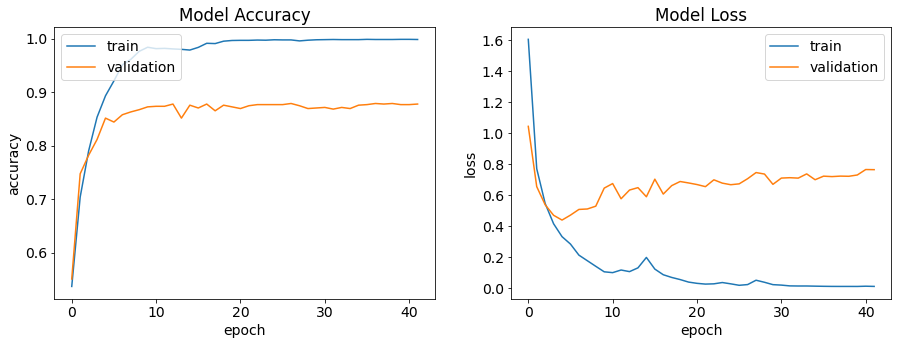

16/16 - 1s - loss: 0.7376 - accuracy: 0.8709
16/16 - 1s - loss: 0.7376 - accuracy: 0.8709
+------------------+--------------------+
|     Metrics      |      Results       |
+------------------+--------------------+
|   Testing Loss   | 0.7375534176826477 |
| Testing Accuracy | 87.08885908126831  |
|  Accuracy Score  | 87.08885616102111  |
| Precision Score  | 87.16112164583059  |
|   Recall Score   | 87.08885616102111  |
|     F1 Score     |  87.0824118790478  |
|  Execution Time  | 57.295897245407104 |
+------------------+--------------------+

--------------------Bi-LSTM-Batch-128-Nodes-128--------------------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 133, 300)          909600    
_________________________________________________________________
bidirectional (Bidirectional (None, 133, 256)          439296    
__________________________

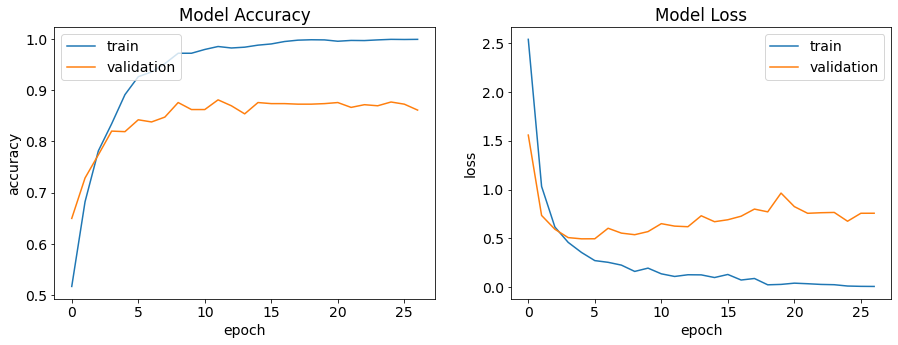

16/16 - 1s - loss: 0.7014 - accuracy: 0.8709
16/16 - 1s - loss: 0.7014 - accuracy: 0.8709
+------------------+--------------------+
|     Metrics      |      Results       |
+------------------+--------------------+
|   Testing Loss   | 0.7013870477676392 |
| Testing Accuracy | 87.08885908126831  |
|  Accuracy Score  | 87.08885616102111  |
| Precision Score  | 87.10449984067228  |
|   Recall Score   | 87.08885616102111  |
|     F1 Score     | 87.08741843776447  |
|  Execution Time  | 41.03097224235535  |
+------------------+--------------------+

--------------------GRU-Batch-128-Nodes-128--------------------

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 133, 300)          909600    
_________________________________________________________________
gru (GRU)                    (None, 133, 128)          165120    
______________________________

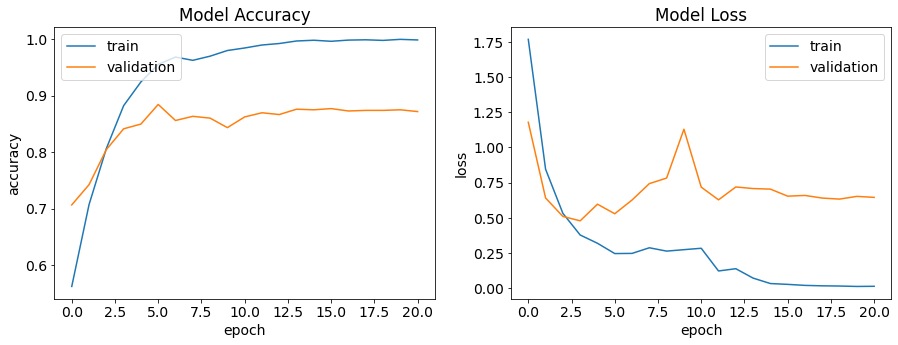

16/16 - 1s - loss: 0.6367 - accuracy: 0.8625
16/16 - 1s - loss: 0.6367 - accuracy: 0.8625
+------------------+--------------------+
|     Metrics      |      Results       |
+------------------+--------------------+
|   Testing Loss   | 0.6367438435554504 |
| Testing Accuracy | 86.25429272651672  |
|  Accuracy Score  | 86.25429553264605  |
| Precision Score  | 86.25785701825957  |
|   Recall Score   | 86.25429553264605  |
|     F1 Score     | 86.25399738187849  |
|  Execution Time  | 19.454593181610107 |
+------------------+--------------------+
                          Name   Accuracy
0     LSTM-Batch-128-Nodes-128  87.088859
1  Bi-LSTM-Batch-128-Nodes-128  87.088859
2      GRU-Batch-128-Nodes-128  86.254293


In [99]:
ExecuteAllDLModels()

In [100]:
df_DL_Group0 = df_DL_results.copy()
df_DL_Group0

Training Loss Training Accuracy  ... Testing Loss Testing Accuracy
LSTM        0.0236805           99.7895  ...     0.737553          87.0889
Bi-LSTM       0.11099           98.5263  ...     0.701387          87.0889
GRU          0.245902           95.5263  ...     0.636744          86.2543

[3 rows x 6 columns]

In [101]:
df_DL_Scores_Group0 = df_DL_Scores.copy()
df_DL_Scores_Group0

Precision Score Recall Score F1 Score Accuracy Score Execution Time
LSTM            87.1611      87.0889  87.0824        87.0889        57.2959
Bi-LSTM         87.1045      87.0889  87.0874        87.0889         41.031
GRU             86.2579      86.2543   86.254        86.2543        19.4546

#### Using Other Group Dataset

In [102]:
Xtrain = Xs_train_seq
Xtest = Xs_test_seq
Xval = Xs_val_seq
ytrain = ystrain_enc
ytest = ystest_enc
yval = ysval_enc
TOTAL_WORDS = WORDS_SAMPLED
WORD_INDEX = Word_Index_Sampled

EPOCH = 50
NUM_CLASSES, ACTIVATION, LOSS = DetermineParameters()

df_DL_results = pd.DataFrame(columns = ['Training Loss', 'Training Accuracy', 'Val. Loss', 'Val. Accuracy', \
                                        'Testing Loss', 'Testing Accuracy'], 
                             index=['LSTM', 'Bi-LSTM', 'GRU']) 
df_DL_Scores = pd.DataFrame(columns = ['Precision Score', 'Recall Score', 'F1 Score', 'Accuracy Score', 'Execution Time'], 
                             index=['LSTM', 'Bi-LSTM', 'GRU'])
DL_results = pd.DataFrame(columns = ['Name', 'Accuracy'])

BATCH = [128]
NODES = [128]

#### Model Execution


--------------------LSTM-Batch-128-Nodes-128--------------------

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 143, 300)          989100    
_________________________________________________________________
lstm_2 (LSTM)                (None, 143, 128)          219648    
_________________________________________________________________
dropout_6 (Dropout)          (None, 143, 128)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18304)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               1830500   
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_____________________________________________________

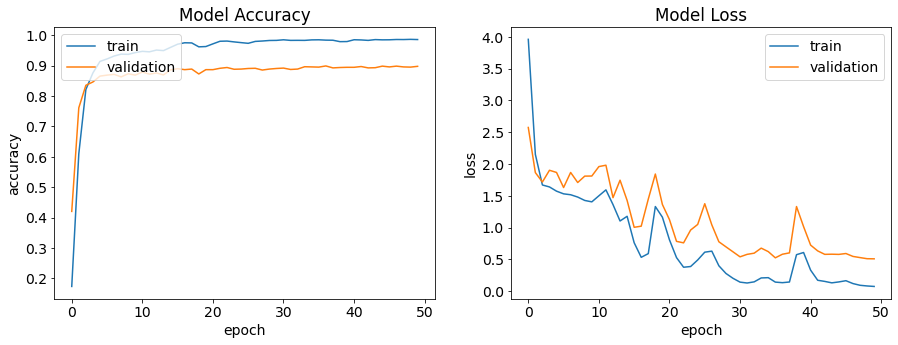

26/26 - 1s - loss: 0.5518 - accuracy: 0.9010
26/26 - 1s - loss: 0.5518 - accuracy: 0.9010
+------------------+-------------------+
|     Metrics      |      Results      |
+------------------+-------------------+
|   Testing Loss   | 0.551795244216919 |
| Testing Accuracy | 90.10228514671326 |
|  Accuracy Score  |  90.1022864019254 |
| Precision Score  | 90.17921665287899 |
|   Recall Score   |  90.1022864019254 |
|     F1 Score     | 89.89608750104657 |
|  Execution Time  | 65.26279187202454 |
+------------------+-------------------+

--------------------Bi-LSTM-Batch-128-Nodes-128--------------------

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 143, 300)          989100    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 143, 256)          439296    
_____________________________________

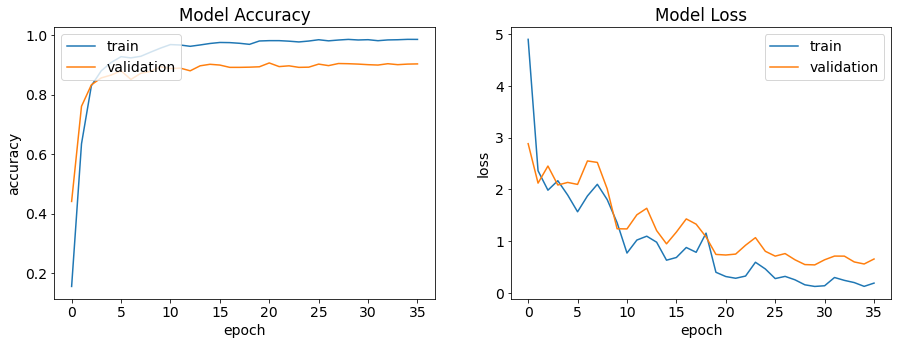

26/26 - 2s - loss: 0.7366 - accuracy: 0.9010
26/26 - 2s - loss: 0.7366 - accuracy: 0.9010
+------------------+--------------------+
|     Metrics      |      Results       |
+------------------+--------------------+
|   Testing Loss   | 0.7365561723709106 |
| Testing Accuracy | 90.10228514671326  |
|  Accuracy Score  |  90.1022864019254  |
| Precision Score  | 90.33959918455811  |
|   Recall Score   |  90.1022864019254  |
|     F1 Score     | 90.01709937368211  |
|  Execution Time  | 81.35018467903137  |
+------------------+--------------------+

--------------------GRU-Batch-128-Nodes-128--------------------

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 143, 300)          989100    
_________________________________________________________________
gru_1 (GRU)                  (None, 143, 128)          165120    
______________________________

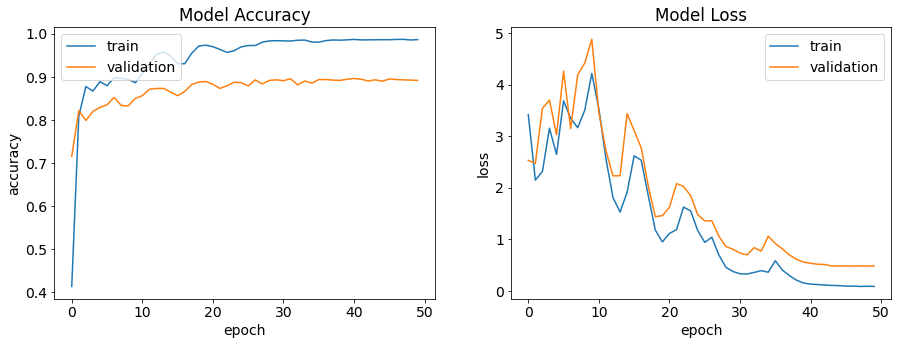

26/26 - 1s - loss: 0.4908 - accuracy: 0.9052
26/26 - 1s - loss: 0.4908 - accuracy: 0.9052
+------------------+---------------------+
|     Metrics      |       Results       |
+------------------+---------------------+
|   Testing Loss   | 0.49079573154449463 |
| Testing Accuracy |  90.52346348762512  |
|  Accuracy Score  |  90.52346570397111  |
| Precision Score  |  90.58838805035633  |
|   Recall Score   |  90.52346570397111  |
|     F1 Score     |  90.39460822635711  |
|  Execution Time  |  61.70781207084656  |
+------------------+---------------------+
                          Name   Accuracy
0     LSTM-Batch-128-Nodes-128  90.102285
1  Bi-LSTM-Batch-128-Nodes-128  90.102285
2      GRU-Batch-128-Nodes-128  90.523463


In [103]:
ExecuteAllDLModels()

In [104]:
df_DL_Others = df_DL_results.copy()
df_DL_Others

Training Loss Training Accuracy  ... Testing Loss Testing Accuracy
LSTM         0.134545           98.4526  ...     0.551795          90.1023
Bi-LSTM      0.317699           98.1464  ...     0.736556          90.1023
GRU          0.132399           98.6783  ...     0.490796          90.5235

[3 rows x 6 columns]

In [105]:
df_DL_Scores_Others = df_DL_Scores.copy()
df_DL_Scores_Others

Precision Score Recall Score F1 Score Accuracy Score Execution Time
LSTM            90.1792      90.1023  89.8961        90.1023        65.2628
Bi-LSTM         90.3396      90.1023  90.0171        90.1023        81.3502
GRU             90.5884      90.5235  90.3946        90.5235        61.7078

## Overall Model Results

In [106]:
def SetHorizontalBarValue(ax):
  # create a list to collect the plt.patches data
  totals = []

  # find the values and append to list
  for i in ax.patches:
    totals.append(i.get_width())

  # set individual bar lables using above list
  total = sum(totals)

  # set individual bar lables using above list
  for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.01, i.get_y()+.2, str(str(round(i.get_width(), 2))))

  # invert for largest on top 
  ax.invert_yaxis()

def PlotResults():
  fig, axes = plt.subplots(1, 2, figsize=(21, 12))
  acc = df_Scores.reset_index().plot(ax=axes[0],
      x="index", y=['Accuracy Score', 'F1 Score'], kind="barh"
  )
  SetHorizontalBarValue(acc)
  axes[0].set_title("Model Performance")
  axes[0].set_xlabel("Metrics (%)")
  axes[0].set_ylabel("Models")
  axes[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

  exectime = df_Scores.reset_index().plot(ax=axes[1],
      x="index", y=['Execution Time'], kind="barh"
  )
  SetHorizontalBarValue(exectime)
  axes[1].set_title("Model Execution")
  axes[1].set_xlabel("Execution Time (seconds)")
  axes[1].set_ylabel("Models")
  
  plt.tight_layout()

### Group 0 Dataset

In [107]:
df_Scores =  pd.concat([df_ML_Group0[['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Execution Time']], df_DL_Scores_Group0])
df_Scores

Accuracy Score Precision Score  ... F1 Score Execution Time
Logistic Regression           91.6544         91.8524  ...  91.6447       0.227701
K-Nearest Neighbors            88.758         89.4942  ...  88.7058        1.07455
Support Vector Machine        91.8508         91.9871  ...  91.8443        23.3751
Naive Bayes                   89.5925         90.1504  ...  89.5566       0.013634
Decision Trees                84.8797         85.6331  ...     84.8        1.54786
Random Forest                 88.8071         89.5551  ...  88.7543        53.4112
Bagging                       87.8252         88.9101  ...  87.7404        113.443
Gradient Boosting             88.4634         88.9263  ...  88.4294        54.4109
XG Boosting                   77.2705         77.2779  ...  77.2688        5.65043
LSTM                          87.0889         87.1611  ...  87.0824        57.2959
Bi-LSTM                       87.0889         87.1045  ...  87.0874         41.031
GRU                           86.2543         86.2579  ...   86.254        19.4546

[12 rows x 5 columns]

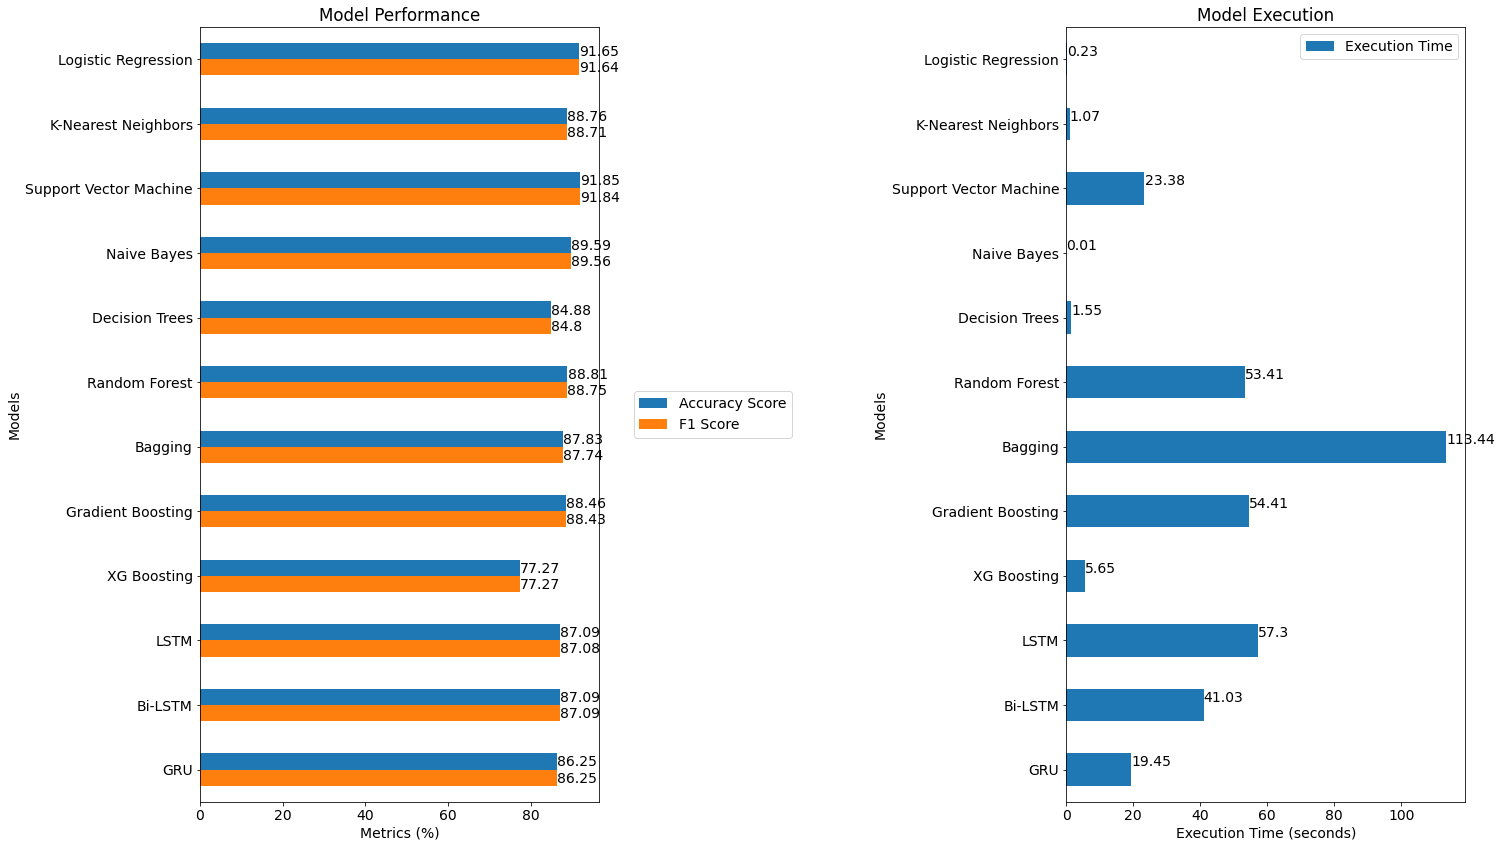

In [108]:
PlotResults()

### Other Group Dataset

In [109]:
df_Scores =  pd.concat([df_ML_Others[['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Execution Time']], df_DL_Scores_Others])
df_Scores

Accuracy Score Precision Score  ... F1 Score Execution Time
Logistic Regression           94.1937          94.184  ...   94.096        38.6424
K-Nearest Neighbors           91.6366         91.9913  ...  91.3716        5.42081
Support Vector Machine        94.4043         94.4466  ...  94.3468        62.0406
Naive Bayes                   93.4116         93.5136  ...  93.3625       0.150626
Decision Trees                92.0277         92.1077  ...  91.8153         3.0239
Random Forest                  93.231         93.3947  ...  93.1066        15.1945
Bagging                        92.509         92.5426  ...   92.336        260.584
Gradient Boosting             92.4789         92.5875  ...   92.367        290.706
XG Boosting                   86.8532         86.8245  ...   86.341        235.779
LSTM                          90.1023         90.1792  ...  89.8961        65.2628
Bi-LSTM                       90.1023         90.3396  ...  90.0171        81.3502
GRU                           90.5235         90.5884  ...  90.3946        61.7078

[12 rows x 5 columns]

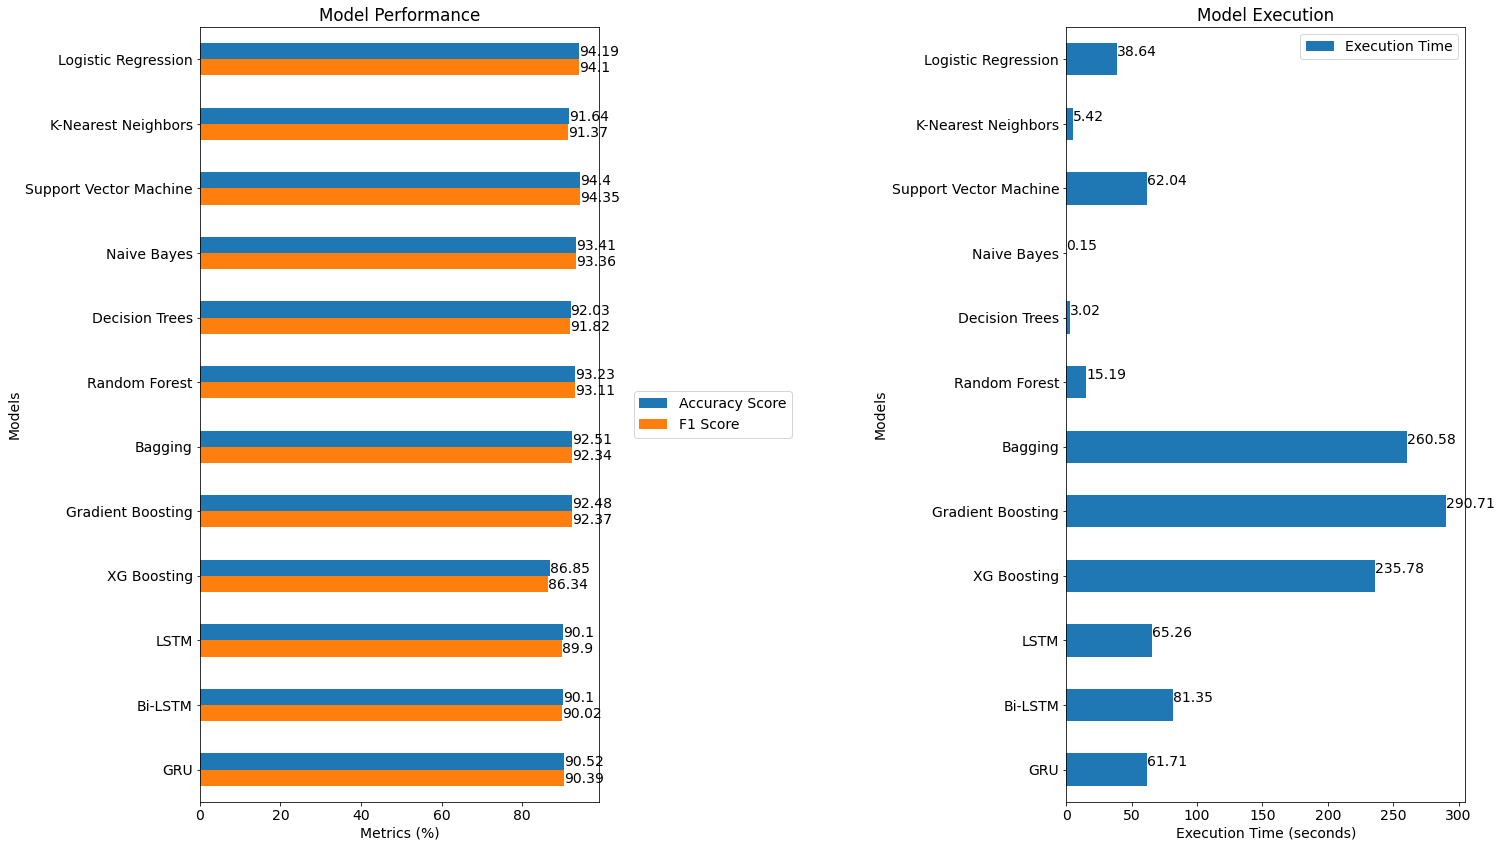

In [110]:
PlotResults()

## Prediction

In [111]:
import random
def GetRandomIntegers(limit):
  if limit > 10:
    limit = 10

  random_list=[]
  for i in range(50):
    if len(random_list) == limit:
      break
    r = random.randint(1,19)
    if r not in random_list: random_list.append(r)
  return random_list

def PredictAssignmentGroup(text, grp0_model, others_model):
  grp0_vec = pickle.load(open('grp0-vectorizer.pkl', 'rb'))
  vec = grp0_vec.transform([text])
  pred_class = grp0_model.predict(vec)

  grp0_enc = pickle.load(open('grp0-encoder.pkl', 'rb'))
  group = grp0_enc.inverse_transform(pred_class)[0]

  if group != 'GRP_0':
    others_vec = pickle.load(open('others-vectorizer.pkl', 'rb'))
    vec = others_vec.transform([text])
    pred_class = others_model.predict(vec)

    others_enc = pickle.load(open('others-encoder.pkl', 'rb'))
    group = others_enc.inverse_transform(pred_class)[0]
  return group

def GetPredictions(num, test_data, mdl1, mdl2):
  # Create separate dataframe to hold the results
  predictions = pd.DataFrame(columns = ['Description', 'Assignment Group', 'Predicted Group'])

  # Loop through the data and take one sample after every 20 step starting with random number num
  for i in range(num, test_data.shape[0], 20):
    grp = PredictAssignmentGroup(test_data[Description][i], mdl1, mdl2)
    res = {'Description' : test_data[Description][i], 'Assignment Group': test_data[AssignmentGroup][i], 'Predicted Group': grp}
    predictions = predictions.append(res, ignore_index=True)

  fname = 'Test-Data-Predictions-' + str(num) + '.xlsx'
  predictions.to_excel(fname)
  return predictions

def CalculateAccuracy(test_results):
  # Check whether Actual & Predicted values are same or not
  rows = test_results.apply(lambda x : True if x['Assignment Group'] == x['Predicted Group'] else False, axis = 1) 
  # Count number of True in the series 
  num_rows = len(rows[rows == True].index)
  return (num_rows / test_results.shape[0]) * 100

In [115]:
from statistics import mean 

# Concatenate test data split which is untouched for predictions
test = pd.concat([X_test, y_test], axis=1)

# Create test data using the indexes of X_test & y_test
test_data = final_df_group0.iloc[list(test.index.values)]
test_data = test_data.reset_index(drop=True)

# Load the best models saved earlier for Predictions
grp0_model = torch.load(filePath + 'grp0-svm-model.pkl')
others_model = torch.load(filePath + 'others-lr-model.pkl')

predictions = []

# Generate random numbers for taking samples from test data and loop through it
nos = GetRandomIntegers(10)
m=0
for no in nos:
  m=m+1
  results = GetPredictions(no, test_data, grp0_model, others_model)
  acc = CalculateAccuracy(results)
  predictions.append(acc)
  print("Prediction Accuracy of Set {0} : {1}".format(str(m), acc))

print("Mean Accuracy of the Test Data Prediction is", mean(predictions))

Prediction Accuracy of Set 1 : 90.0990099009901
Prediction Accuracy of Set 2 : 92.15686274509804
Prediction Accuracy of Set 3 : 91.17647058823529
Prediction Accuracy of Set 4 : 87.25490196078431
Prediction Accuracy of Set 5 : 95.09803921568627
Prediction Accuracy of Set 6 : 95.09803921568627
Prediction Accuracy of Set 7 : 93.13725490196079
Prediction Accuracy of Set 8 : 94.11764705882352
Prediction Accuracy of Set 9 : 94.11764705882352
Prediction Accuracy of Set 10 : 97.02970297029702
Mean Accuracy of the Test Data Prediction is 92.92855756163851


Automatic Ticket Assignment problem statement is a classical case of Multi-Class text classification problems. To achieve the goal of building a Classifier that can classify the tickets we have implemented the below steps
*  **EDA, Data Pre-processing & Visualization**
    *  Analyzing the structure of data i.e feature & target columns
    *  Merging small groups in target column to manage data imbalance
    *  Dropping non essential column & duplicate data
    *  Handling missing values
    *  Visualizing the text data
    *  Merging text features together for easier processing


*  **Text Pre-processing**
    *  Decode unicode characters using ftfy
    *  Language translation for foreign language text using google translate
    *  Text Cleaning i.e. removing noise from text using clean text & regex
    *  Lemmatization using spacy
    *  Stop Word removal using spacy & custom set of words
    *  Word Translation to translate individual words
    *  Skip non english words to improve text quality
    *  Identified patterns in the data & handled redundant text


*  **Strategic Approach of splitting data into logical datasets to manage data imbalance**
    *  Dataset to classify between GRP_0 & Others
    *  Dataset to classify between the remaining non GRP_0 assignment groups
    *  Over sampling the datasets for better balance


*  **Model Selection & Model Building**
    *  Machine Learning models
        *  Logistic Regression
        *  K-Nearest Neighbors
        *  Support Vector Machine
        *  Naive Bayes
        *  Decision Trees
        *  Random Forest
        *  Bagging
        *  Gradient Boosting
        *  XG Boosting
    *  Deep Learning models
        *  LSTM
        *  Bi-directional LSTM
        *  GRU


*  **Hypertuning Models & Model Evaluation**
    *  Evaluation Metrics used are Precision, Recall, F1 score & Accuracy Score
    *  Considered K-Fold Cross Validation score & Execution time of the models


*  **Identify Best Models based on Evaluation Metrics**
    *  **SVM** model has little edge over Logistic Regression, Random Forest & Bi-LSTM models to classify between GRP_0 & Others with **accuracy of 91.85%, f1 score of 91.84%, cross validation score of 88.82% and execution time of 22.37 seconds**
    *  SVM and Logistic Regression models were neck-to-neck (almost similar) closely followed by Random Forest model to classify between the remaining non GRP_0 assignment group. But, we selected **Logistic Regression** purely to introduce diversity & was giving better prediction results. It has **accuracy of 94.19%, f1 score of 94.10%, cross validation score of 92.51% and execution time of 38.66 seconds**

    
*  **Model Prediction**
    *  Combine both models such that Test data will first run through Logistic Regression model.
        *  If Predicted Output = GRP_0 -> Processing ends & return the assignment group output
        *  If Predicted Output = Others -> Continue processing with SVM model and return the assignment group output this model.
    *  Calculate Prediction Accuracy after combining models
        *  Structured 10 random test data sets each of around 100 samples from the unused/unprocessed Testing set.
        *  Calculated the prediction accuracy of each set & derived the mean
*  The strategic approach of using two models resulted in **overall prediction accuracy of around 93%**. It is a jump of **18% in accuracy then the existing systen which has 75% accuracy** 
